# 🏥 Clasificación Biomédica Multilabel - Versión Mejorada

## 📋 Descripción del Proyecto
Sistema de clasificación automática de documentos biomédicos en múltiples categorías:
- **neurological**: Trastornos neurológicos
- **hepatorenal**: Problemas hepáticos y renales  
- **cardiovascular**: Enfermedades cardiovasculares

## 🎯 Objetivos de Mejora
1. **Superar F1=0.9** en validación con técnicas avanzadas
2. **Prevenir overfitting** mediante regularización y validación cruzada
3. **Modelo baseline dummy** como referencia mínima
4. **Visualizaciones estéticas** con seaborn/plotly
5. **Análisis robusto** de data leakage y generalización
6. **Ensemble methods** para maximizar performance

## 📊 Métricas Objetivo
- **F1-macro > 0.90** (actual benchmark)
- **F1-weighted > 0.92** (objetivo mejorado)
- **Precisión balanceada** entre clases
- **Robustez** ante diferentes thresholds

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

In [ ]:
# ===========================
# IMPORTS Y CONFIGURACIÓN INICIAL MEJORADA
# ===========================

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
import re
import string
from typing import List, Dict, Tuple
from datetime import datetime

# Transformers y ML
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, AutoModel,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    get_linear_schedule_with_warmup, DataCollatorWithPadding
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    f1_score, hamming_loss, classification_report,
    average_precision_score, roc_auc_score, confusion_matrix,
    multilabel_confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.dummy import DummyClassifier

# Configuración de reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Configuración de dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Dispositivo: {device}")
print(f"📅 Ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Configuraciones globales mejoradas
plt.style.use('default')  # Cambiar a default para mejor control
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.1)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Colores consistentes para visualizaciones
COLORS = {
    'neurological': '#E74C3C',    # Rojo
    'hepatorenal': '#3498DB',     # Azul
    'cardiovascular': '#2ECC71',  # Verde
    'mixed': '#9B59B6'            # Púrpura
}

🚀 Dispositivo: cuda
📅 Ejecución: 2025-09-22 02:19:02


In [ ]:
df = pd.read_csv("challenge_data-18-ago.csv", sep=";")
df["text"] = df["title"] + " " + df["abstract"]
df["labels"] = df["group"].apply(lambda x: x.split("|"))

In [ ]:
# ===========================
# ANÁLISIS INICIAL DE DATOS MEJORADO
# ===========================

print("📊 RESUMEN INICIAL DEL DATASET")
print("="*50)
print(f"Total de documentos: {len(df):,}")
print(f"Columnas: {list(df.columns)}")
print(f"Memoria usada: {df.memory_usage().sum() / 1024**2:.2f} MB")

# Análisis de categorías
all_labels = [lab for labs in df["labels"] for lab in labs]
unique_labels = sorted(set(all_labels))
print(f"\nCategorías únicas: {unique_labels}")
print(f"Total etiquetas asignadas: {len(all_labels):,}")

# Distribución de número de etiquetas por documento
labels_per_doc = df["labels"].apply(len)
print(f"\n📈 DISTRIBUCIÓN DE ETIQUETAS POR DOCUMENTO:")
print(f"Promedio: {labels_per_doc.mean():.2f}")
print(f"Mediana: {labels_per_doc.median():.0f}")
print(f"Documentos con 1 etiqueta: {(labels_per_doc == 1).sum():,} ({(labels_per_doc == 1).mean()*100:.1f}%)")
print(f"Documentos con 2+ etiquetas: {(labels_per_doc > 1).sum():,} ({(labels_per_doc > 1).mean()*100:.1f}%)")

# Análisis de texto
print(f"\n📝 ANÁLISIS DE LONGITUD DE TEXTO:")
print(f"Título - Promedio: {df['title'].str.len().mean():.0f} caracteres")
print(f"Abstract - Promedio: {df['abstract'].str.len().mean():.0f} caracteres")
print(f"Texto completo - Promedio: {df['text'].str.len().mean():.0f} caracteres")

# Mostrar primeras filas
print(f"\n🔍 PRIMERAS 3 FILAS:")
display(df[['title', 'group']].head(3))

# Análisis de balance de clases
label_counts = pd.Series(all_labels).value_counts()
print(f"\n⚖️ BALANCE DE CLASES:")
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{label:15}: {count:4,} documentos ({percentage:5.1f}%)")

# Calcular Imbalance Ratio
max_count = label_counts.max()
min_count = label_counts.min()
imbalance_ratio = max_count / min_count
print(f"\nRatio de desbalance: {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print("⚠️  Dataset significativamente desbalanceado - usar class weights")
elif imbalance_ratio > 1.5:
    print("⚡ Dataset moderadamente desbalanceado - monitorear")
else:
    print("✅ Dataset relativamente balanceado")

📊 RESUMEN INICIAL DEL DATASET
Total de documentos: 3,565
Columnas: ['title', 'abstract', 'group', 'text', 'labels']
Memoria usada: 0.14 MB

Categorías únicas: ['cardiovascular', 'hepatorenal', 'neurological', 'oncological']
Total etiquetas asignadas: 4,745

📈 DISTRIBUCIÓN DE ETIQUETAS POR DOCUMENTO:
Promedio: 1.33
Mediana: 1
Documentos con 1 etiqueta: 2,473 (69.4%)
Documentos con 2+ etiquetas: 1,092 (30.6%)

📝 ANÁLISIS DE LONGITUD DE TEXTO:
Título - Promedio: 69 caracteres
Abstract - Promedio: 697 caracteres
Texto completo - Promedio: 767 caracteres

🔍 PRIMERAS 3 FILAS:


,title,group
0,Adrenoleukodystrophy: survey of 303 cases: bio...,neurological|hepatorenal
1,endoscopy reveals ventricular tachycardia secrets,neurological
2,dementia and cholecystitis: organ interplay,hepatorenal



⚖️ BALANCE DE CLASES:
neurological   : 1,785 documentos ( 50.1%)
cardiovascular : 1,268 documentos ( 35.6%)
hepatorenal    : 1,091 documentos ( 30.6%)
oncological    :  601 documentos ( 16.9%)

Ratio de desbalance: 2.97
⚡ Dataset moderadamente desbalanceado - monitorear


# 📊 Análisis Exploratorio de Datos (EDA) Mejorado

Esta sección presenta visualizaciones estéticas y análisis profundo de los datos biomédicos.

In [ ]:
# ===========================
# CONFIGURACIÓN VISUAL MEJORADA
# ===========================

# Configuración matplotlib/seaborn más estética
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3
})

# Paleta de colores personalizada
custom_palette = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
sns.set_palette(custom_palette)

print("✨ Configuración visual aplicada")

✨ Configuración visual aplicada


TypeError: 'numpy.ndarray' object is not callable

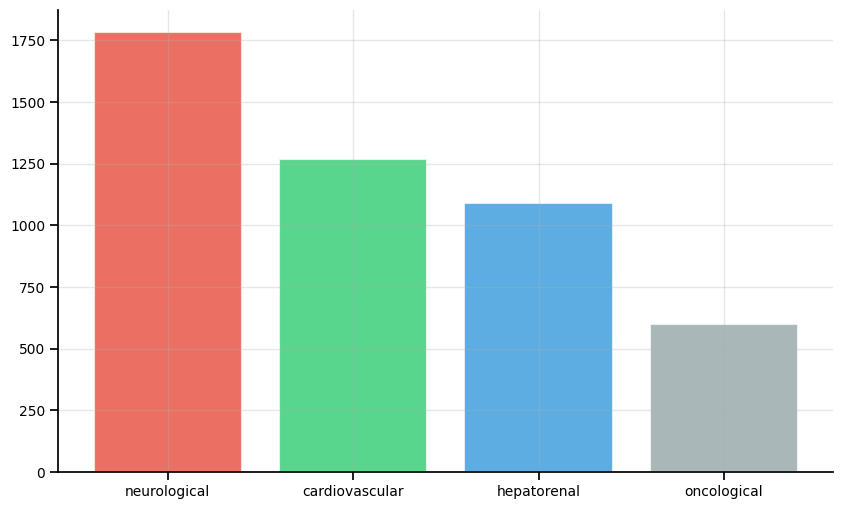

In [ ]:
# ============================================================
# 1. DISTRIBUCIÓN DE CATEGORÍAS - VISUALIZACIÓN INTERACTIVA
# ============================================================

all_labels = [lab for labs in df["labels"] for lab in labs]
label_counts = pd.Series(all_labels).value_counts()

# Gráfico interactivo con Plotly
fig = go.Figure()

# Agregar barras con colores personalizados
colors = [COLORS.get(label, '#95A5A6') for label in label_counts.index]

fig.add_trace(go.Bar(
    x=label_counts.index,
    y=label_counts.values,
    marker_color=colors,
    text=[f'{count:,}<br>({count/len(df)*100:.1f}%)' for count in label_counts.values],
    textposition='outside',
    hovertemplate='<b>%{x}</b><br>' +
                  'Documentos: %{y:,}<br>' +
                  'Porcentaje: %{text}<br>' +
                  '<extra></extra>'
))

fig.update_layout(
    title={
        'text': '📊 Distribución de Categorías Biomédicas',
        'x': 0.5,
        'xanchor': 'center',
        'font': {'size': 18}
    },
    xaxis_title='Categoría Médica',
    yaxis_title='Número de Documentos',
    template='plotly_white',
    showlegend=False,
    height=500,
    margin=dict(t=80, b=50, l=50, r=50)
)

fig.show()

# Versión matplotlib para backup
plt.figure(figsize=(10, 6))
bars = plt.bar(label_counts.index, label_counts.values,
               color=[COLORS.get(label, '#95A5A6') for label in label_counts.index],
               alpha=0.8, edgecolor='white', linewidth=1.5)

# Añadir valores en las barras
for i, (label, count) in enumerate(label_counts.items()):
    plt.text(i, count + max(label_counts.values())*0.01,
             f'{count:,}\n({count/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.title('📊 Distribución de Categorías Biomédicas', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Categoría Médica', fontsize=12)
plt.ylabel('Número de Documentos', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Estadísticas adicionales
print("📈 ESTADÍSTICAS DE DISTRIBUCIÓN:")
print(f"Categoría más frecuente: {label_counts.index[0]} ({label_counts.iloc[0]:,} docs)")
print(f"Categoría menos frecuente: {label_counts.index[-1]} ({label_counts.iloc[-1]:,} docs)")
print(f"Coeficiente de variación: {label_counts.std()/label_counts.mean():.3f}")
print(f"Ratio máximo/mínimo: {label_counts.max()/label_counts.min():.2f}")

📊 ANÁLISIS MULTI-LABEL:
Documentos con una sola etiqueta: 2,473 (69.4%)
Documentos multi-label: 1,092 (30.6%)


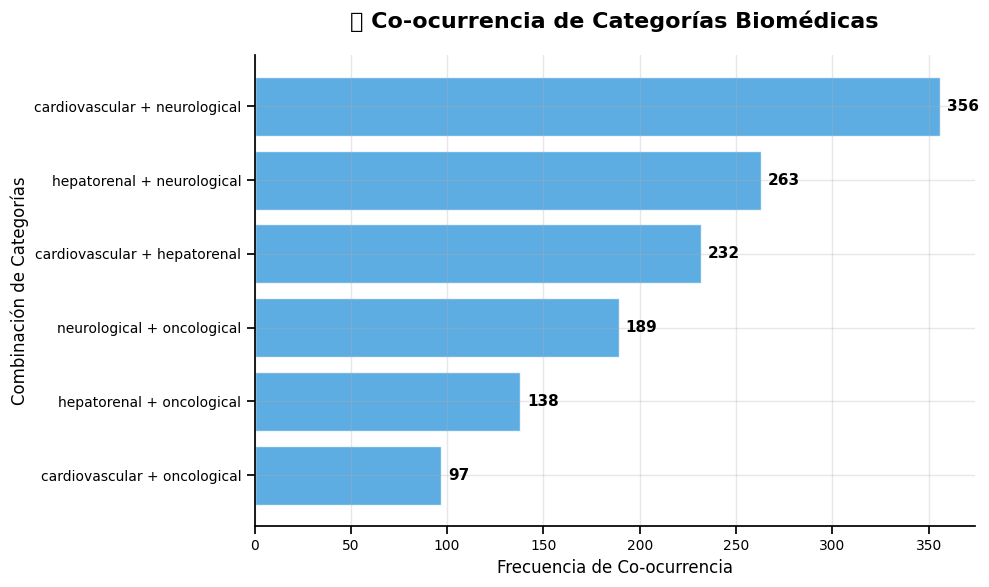

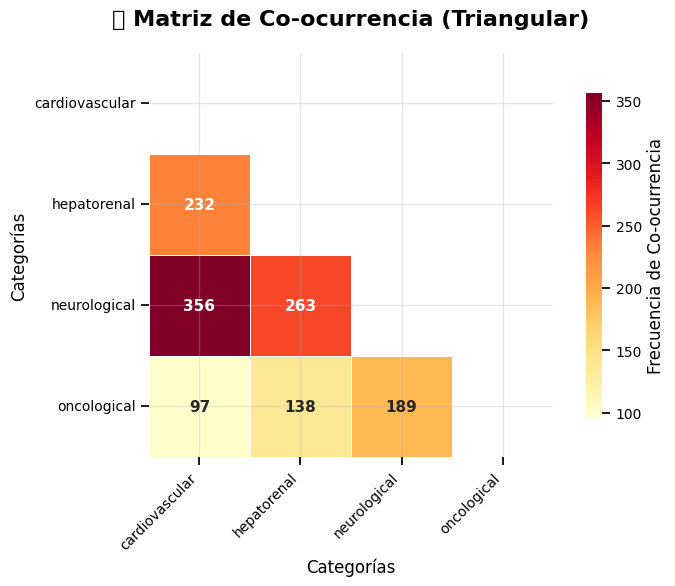


📊 ESTADÍSTICAS DE CO-OCURRENCIA:
Total de co-ocurrencias: 1,275
Pares únicos encontrados: 6
Combinación más común: cardiovascular + neurological (356 veces)


In [ ]:
# ============================================================
# 2. ANÁLISIS DE CO-OCURRENCIA DE CATEGORÍAS
# ============================================================

# Contar pares de categorías
pair_counts = Counter()
for labs in df["labels"]:
    if len(labs) > 1:
        for pair in combinations(sorted(labs), 2):
            pair_counts[pair] += 1

# Análisis de documentos multi-label
multilabel_docs = df[df["labels"].apply(len) > 1]
single_label_docs = df[df["labels"].apply(len) == 1]

print(f"📊 ANÁLISIS MULTI-LABEL:")
print(f"Documentos con una sola etiqueta: {len(single_label_docs):,} ({len(single_label_docs)/len(df)*100:.1f}%)")
print(f"Documentos multi-label: {len(multilabel_docs):,} ({len(multilabel_docs)/len(df)*100:.1f}%)")

if pair_counts:
    # Crear DataFrame de pares
    pair_df = pd.DataFrame(pair_counts.items(), columns=["Pares", "Frecuencia"])
    pair_df["Pares_str"] = pair_df["Pares"].apply(lambda x: " + ".join(x))
    pair_df = pair_df.sort_values("Frecuencia", ascending=True)

    # Gráfico horizontal de pares
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(pair_df["Pares_str"], pair_df["Frecuencia"],
                   color='#3498DB', alpha=0.8, edgecolor='white', linewidth=1)

    # Añadir valores en las barras
    for i, (pair, freq) in enumerate(zip(pair_df["Pares_str"], pair_df["Frecuencia"])):
        ax.text(freq + max(pair_df["Frecuencia"])*0.01, i,
                f'{freq:,}', va='center', fontweight='bold')

    ax.set_title('🔗 Co-ocurrencia de Categorías Biomédicas', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Frecuencia de Co-ocurrencia', fontsize=12)
    ax.set_ylabel('Combinación de Categorías', fontsize=12)
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Matriz de co-ocurrencia mejorada
    unique_labels = sorted(set(all_labels))
    cooccurrence_matrix = pd.DataFrame(0, index=unique_labels, columns=unique_labels)

    for labs in df["labels"]:
        for i in labs:
            for j in labs:
                cooccurrence_matrix.loc[i, j] += 1

    # Heatmap estético
    plt.figure(figsize=(8, 6))
    mask = np.triu(np.ones_like(cooccurrence_matrix, dtype=bool))  # Máscara triangular superior

    sns.heatmap(cooccurrence_matrix,
                annot=True,
                fmt='d',
                cmap='YlOrRd',
                mask=mask,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8, "label": "Frecuencia de Co-ocurrencia"},
                annot_kws={"fontsize": 11, "fontweight": "bold"})

    plt.title('🔥 Matriz de Co-ocurrencia (Triangular)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Categorías', fontsize=12)
    plt.ylabel('Categorías', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Estadísticas de co-ocurrencia
    total_pairs = sum(pair_counts.values())
    print(f"\n📊 ESTADÍSTICAS DE CO-OCURRENCIA:")
    print(f"Total de co-ocurrencias: {total_pairs:,}")
    print(f"Pares únicos encontrados: {len(pair_counts)}")
    if pair_counts:
        most_common = max(pair_counts, key=pair_counts.get)
        print(f"Combinación más común: {' + '.join(most_common)} ({pair_counts[most_common]:,} veces)")
else:
    print("ℹ️ No se encontraron co-ocurrencias (todos los documentos tienen una sola etiqueta)")

📊 ESTADÍSTICAS DESCRIPTIVAS DE LONGITUD:
       Títulos  Abstracts  Texto Completo
count  3565.00    3565.00         3565.00
mean      8.73     100.06          108.79
std       4.88      93.07           96.62
min       2.00      22.00           28.00
25%       5.00      31.00           37.00
50%       7.00      37.00           43.00
75%      11.00     172.00          185.00
max      38.00     525.00          535.00



🔍 ANÁLISIS DE OUTLIERS:
Títulos        : 118 outliers (3.3%)
                Rango normal: [-4, 20] palabras
                Outlier más extremo: 38 palabras
Abstracts      :  25 outliers (0.7%)
                Rango normal: [-180, 384] palabras
                Outlier más extremo: 525 palabras
Texto Completo :  20 outliers (0.6%)
                Rango normal: [-185, 407] palabras
                Outlier más extremo: 535 palabras


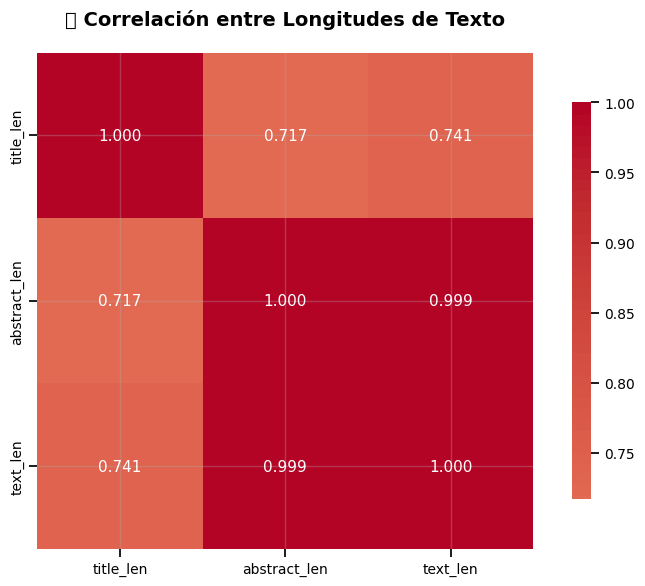

In [ ]:
# ============================================================
# 3. ANÁLISIS AVANZADO DE LONGITUD DE TEXTOS
# ============================================================

df["title_len"] = df["title"].str.split().apply(len)
df["abstract_len"] = df["abstract"].str.split().apply(len)
df["text_len"] = df["text"].str.split().apply(len)

# Estadísticas descriptivas
text_stats = pd.DataFrame({
    'Títulos': df["title_len"].describe(),
    'Abstracts': df["abstract_len"].describe(),
    'Texto Completo': df["text_len"].describe()
}).round(2)

print("📊 ESTADÍSTICAS DESCRIPTIVAS DE LONGITUD:")
print(text_stats)

# Gráfico con subplots mejorado
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Distribución de Títulos', 'Distribución de Abstracts',
                   'Comparación Boxplot', 'Longitud vs Categoría'],
    specs=[[{"type": "histogram"}, {"type": "histogram"}],
           [{"type": "box"}, {"type": "violin"}]]
)

# Histogramas
fig.add_trace(go.Histogram(x=df["title_len"], name="Títulos",
                          marker_color='#E74C3C', opacity=0.7,
                          nbinsx=20), row=1, col=1)

fig.add_trace(go.Histogram(x=df["abstract_len"], name="Abstracts",
                          marker_color='#3498DB', opacity=0.7,
                          nbinsx=20), row=1, col=2)

# Boxplots comparativos
for i, (col, name, color) in enumerate([('title_len', 'Títulos', '#E74C3C'),
                                       ('abstract_len', 'Abstracts', '#3498DB')]):
    fig.add_trace(go.Box(y=df[col], name=name, marker_color=color), row=2, col=1)

# Análisis por categoría (violin plot)
text_by_category = []
categories = []
for label in df["labels"]:
    main_category = label[0] if len(label) > 0 else 'unknown'
    categories.append(main_category)

df['main_category'] = categories

for cat in df['main_category'].unique():
    cat_data = df[df['main_category'] == cat]['text_len']
    fig.add_trace(go.Violin(y=cat_data, name=cat,
                           marker_color=COLORS.get(cat, '#95A5A6')), row=2, col=2)

fig.update_layout(height=800, showlegend=True,
                 title_text="📏 Análisis Completo de Longitud de Textos")
fig.show()

# Análisis de outliers
print(f"\n🔍 ANÁLISIS DE OUTLIERS:")
for col, name in [('title_len', 'Títulos'), ('abstract_len', 'Abstracts'), ('text_len', 'Texto Completo')]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{name:15}: {len(outliers):3,} outliers ({len(outliers)/len(df)*100:.1f}%)")

    if len(outliers) > 0:
        print(f"                Rango normal: [{lower_bound:.0f}, {upper_bound:.0f}] palabras")
        print(f"                Outlier más extremo: {df[col].max():.0f} palabras")

# Correlación entre longitudes
correlation_matrix = df[['title_len', 'abstract_len', 'text_len']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8})
plt.title('📊 Correlación entre Longitudes de Texto', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

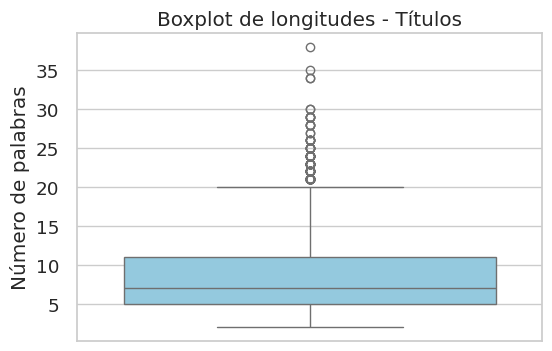

In [ ]:
# ============================================================
# 3B. Boxplots individuales (dos plots separados)
# ============================================================

# Boxplot para títulos
plt.figure(figsize=(6,4))
sns.boxplot(y=df["title_len"], color="skyblue")
plt.title("Boxplot de longitudes - Títulos")
plt.ylabel("Número de palabras")
plt.show()

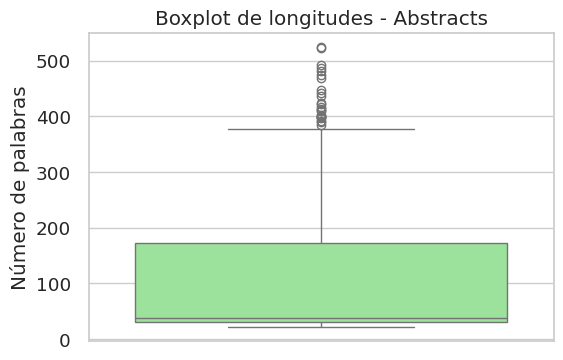

In [ ]:
# Boxplot para abstracts
plt.figure(figsize=(6,4))
sns.boxplot(y=df["abstract_len"], color="lightgreen")
plt.title("Boxplot de longitudes - Abstracts")
plt.ylabel("Número de palabras")
plt.show()

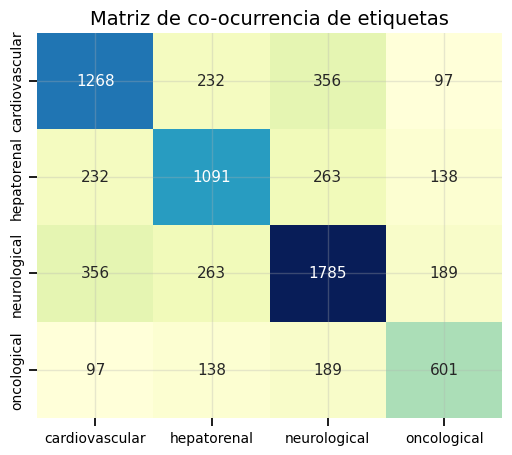

In [ ]:
# ============================================================
# 4. Co-ocurrencia de etiquetas (heatmap)
# ============================================================
unique_labels = sorted(set(all_labels))
co_matrix = pd.DataFrame(0, index=unique_labels, columns=unique_labels)

for labs in df["labels"]:
    for i in labs:
        for j in labs:
            co_matrix.loc[i, j] += 1

plt.figure(figsize=(6,5))
sns.heatmap(co_matrix, annot=True, cmap="YlGnBu", fmt="d", cbar=False)
plt.title("Matriz de co-ocurrencia de etiquetas")
plt.show()

✅ Usando stopwords de NLTK
🧹 Procesando texto...


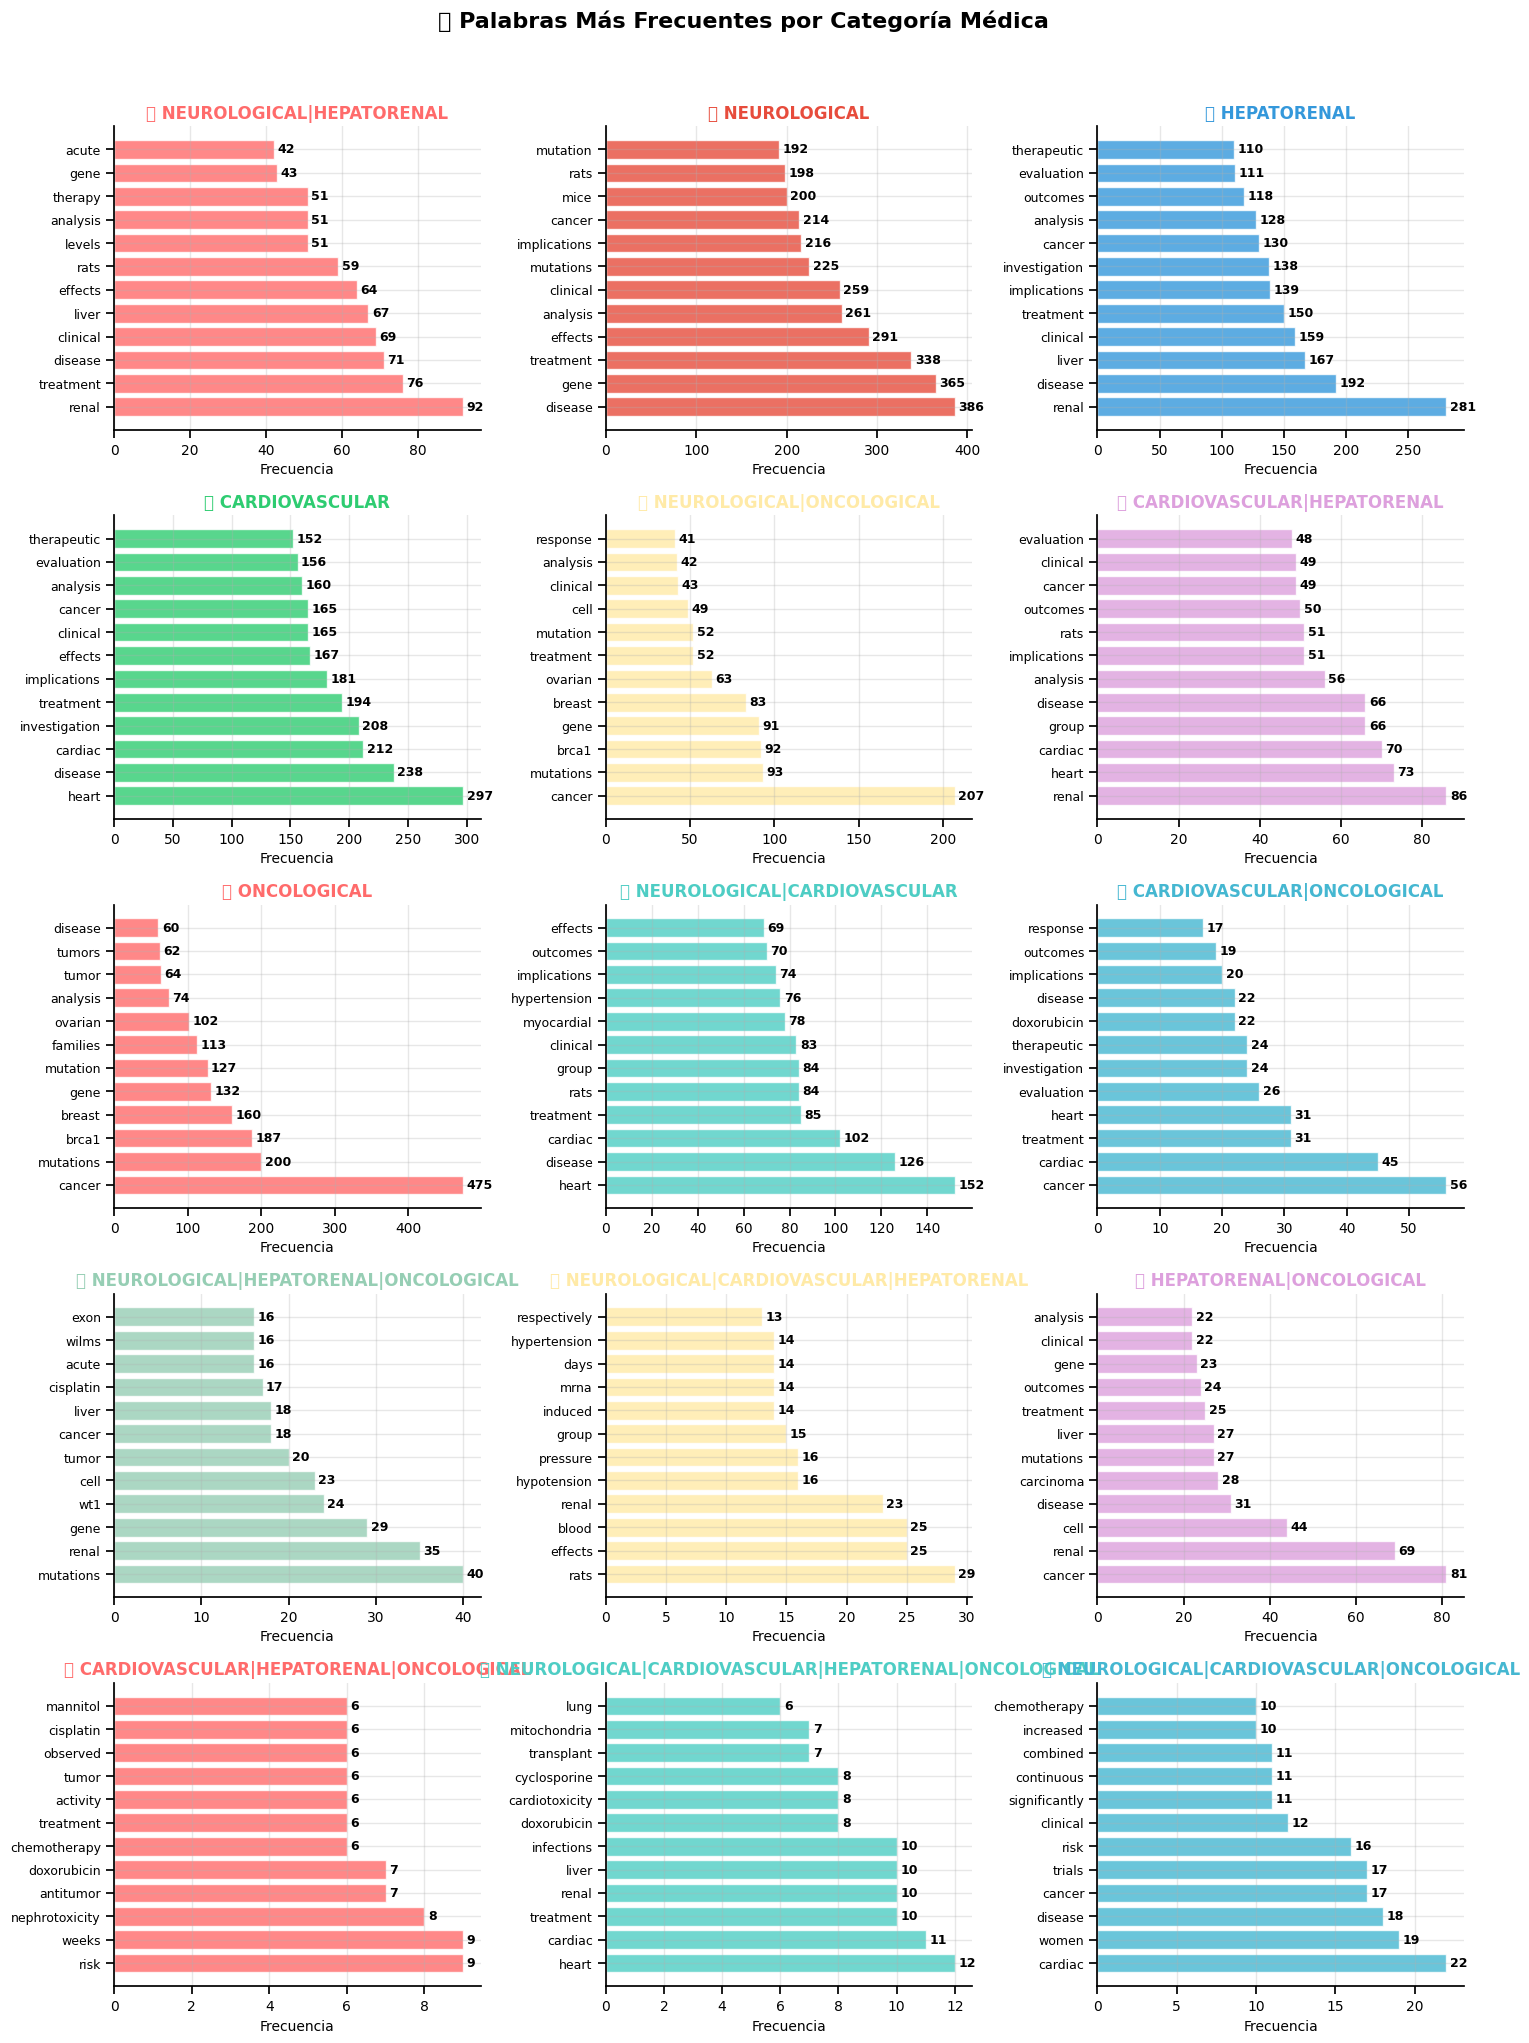


🔍 ANÁLISIS DE VOCABULARIO DISTINTIVO:
NEUROLOGICAL|HEPATORENAL: renal, treatment, disease, clinical, liver
NEUROLOGICAL   : disease, gene, treatment, effects, analysis
HEPATORENAL    : renal, disease, liver, clinical, treatment
CARDIOVASCULAR : heart, disease, cardiac, investigation, treatment
NEUROLOGICAL|ONCOLOGICAL: cancer, mutations, brca1, gene, breast
CARDIOVASCULAR|HEPATORENAL: renal, heart, cardiac, group, disease
ONCOLOGICAL    : cancer, mutations, brca1, breast, gene
NEUROLOGICAL|CARDIOVASCULAR: heart, disease, cardiac, treatment, rats
CARDIOVASCULAR|ONCOLOGICAL: cancer, cardiac, treatment, heart, evaluation
NEUROLOGICAL|HEPATORENAL|ONCOLOGICAL: mutations, renal, gene, wt1, cell
NEUROLOGICAL|CARDIOVASCULAR|HEPATORENAL: rats, effects, blood, renal, hypotension
HEPATORENAL|ONCOLOGICAL: cancer, renal, cell, disease, carcinoma
CARDIOVASCULAR|HEPATORENAL|ONCOLOGICAL: risk, weeks, nephrotoxicity, antitumor, doxorubicin
NEUROLOGICAL|CARDIOVASCULAR|HEPATORENAL|ONCOLOGICAL: heart, ca

In [ ]:
# ================================
# 4. ANÁLISIS AVANZADO DE VOCABULARIO POR CATEGORÍA
# ================================

# Nota: Si NLTK no está disponible, usaremos stopwords básicas
try:
    import nltk
    from nltk.corpus import stopwords
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('english'))
    print("✅ Usando stopwords de NLTK")
except:
    # Stopwords básicas en caso de que NLTK no esté disponible
    stop_words = set([
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by',
        'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did',
        'will', 'would', 'could', 'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those'
    ])
    print("⚠️ Usando stopwords básicas (NLTK no disponible)")

# Stopwords médicas adicionales
medical_stop_words = {
    'study', 'studies', 'patient', 'patients', 'results', 'result', 'conclusion',
    'background', 'methods', 'objective', 'purpose', 'design', 'setting',
    'participants', 'intervention', 'outcome', 'conclusions', 'abstract'
}
stop_words.update(medical_stop_words)

def clean_text_advanced(text):
    """Limpieza avanzada de texto médico"""
    if pd.isna(text):
        return []

    text = str(text).lower()
    # Preservar términos médicos importantes (con guiones, números)
    text = re.sub(r'[^\w\s\-]', ' ', text)  # Mantener guiones
    words = text.split()

    # Filtrar palabras
    words = [w for w in words if (
        len(w) > 2 and                    # Más de 2 caracteres
        w not in stop_words and           # No stopwords
        not w.isdigit() and              # No solo números
        not (len(w) < 4 and w.isalpha())  # Evitar abreviaciones muy cortas
    )]

    return words

# Aplicar limpieza
print("🧹 Procesando texto...")
df["title_clean"] = df["title"].apply(clean_text_advanced)
df["abstract_clean"] = df["abstract"].apply(clean_text_advanced)

def analyze_vocabulary_by_group(df, column, group_col="group", top_n=15):
    """Análisis avanzado de vocabulario por grupo"""
    group_analysis = {}

    for group in df[group_col].unique():
        group_docs = df[df[group_col] == group]

        # Concatenar todas las palabras del grupo
        all_words = []
        for word_list in group_docs[column]:
            all_words.extend(word_list)

        # Contar frecuencias
        word_freq = Counter(all_words)

        # Crear DataFrame
        freq_df = pd.DataFrame(word_freq.most_common(top_n),
                              columns=["word", "count"])
        freq_df["group"] = group
        freq_df["percentage"] = (freq_df["count"] / len(all_words)) * 100

        group_analysis[group] = freq_df

    return pd.concat(group_analysis.values(), ignore_index=True)

# Análizar vocabulario por grupo
vocab_analysis = analyze_vocabulary_by_group(df, "abstract_clean", "group", top_n=12)

# Crear visualización mejorada
unique_groups = vocab_analysis["group"].unique()
n_groups = len(unique_groups)

# Calcular filas y columnas para el grid
cols = 3 if n_groups > 6 else 2 if n_groups > 2 else 1
rows = int(np.ceil(n_groups / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
if rows == 1 and cols == 1:
    axes = [axes]
elif rows == 1 or cols == 1:
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
else:
    axes = axes.flatten()

# Colores por grupo
group_colors = {group: COLORS.get(group, custom_palette[i % len(custom_palette)])
                for i, group in enumerate(unique_groups)}

for i, group in enumerate(unique_groups):
    if i >= len(axes):
        break

    subset = vocab_analysis[vocab_analysis["group"] == group]

    # Crear gráfico horizontal
    bars = axes[i].barh(subset["word"], subset["count"],
                       color=group_colors[group], alpha=0.8, edgecolor='white', linewidth=1)

    # Añadir valores en las barras
    for j, (word, count) in enumerate(zip(subset["word"], subset["count"])):
        axes[i].text(count + max(subset["count"])*0.01, j,
                    f'{count:,}', va='center', ha='left', fontweight='bold', fontsize=9)

    axes[i].set_title(f'🏷️ {group.upper()}', fontsize=12, fontweight='bold',
                     color=group_colors[group])
    axes[i].set_xlabel('Frecuencia', fontsize=10)
    axes[i].grid(axis='x', alpha=0.3)
    axes[i].tick_params(axis='y', labelsize=9)

# Eliminar subplots vacíos
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('📚 Palabras Más Frecuentes por Categoría Médica',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Análisis de palabras distintivas
print("\n🔍 ANÁLISIS DE VOCABULARIO DISTINTIVO:")
print("="*60)

for group in unique_groups:
    group_words = vocab_analysis[vocab_analysis["group"] == group]["word"].tolist()[:5]
    print(f"{group.upper():15}: {', '.join(group_words)}")

# Estadísticas de vocabulario
print(f"\n📊 ESTADÍSTICAS DE VOCABULARIO:")
total_vocab = set()
for word_list in df["abstract_clean"]:
    total_vocab.update(word_list)

print(f"Vocabulario único total: {len(total_vocab):,} palabras")
print(f"Promedio palabras/abstract: {df['abstract_clean'].apply(len).mean():.1f}")

# Análisis de diversidad léxica por grupo
print(f"\n📈 DIVERSIDAD LÉXICA POR GRUPO:")
for group in unique_groups:
    group_words = []
    for word_list in df[df["group"] == group]["abstract_clean"]:
        group_words.extend(word_list)

    unique_words = len(set(group_words))
    total_words = len(group_words)
    diversity = unique_words / total_words if total_words > 0 else 0

    print(f"{group:15}: {diversity:.3f} ({unique_words:,}/{total_words:,})")

# 🤖 Modelado Avanzado con Validación Anti-Overfitting

Esta sección implementa:
- **Modelo Baseline Dummy** para establecer benchmark mínimo
- **Análisis de Data Leakage** y validación robusta  
- **Arquitecturas mejoradas** con regularización adaptativa
- **Ensemble methods** para maximizar performance
- **Validación exhaustiva** anti-overfitting

In [ ]:
# ===========================
# AUMENTO DE DATOS (DATA AUGMENTATION) — ACTUALIZADO
# ===========================
import re
import numpy as np

class TextAugmentation:
    """Técnicas de aumento de datos simples y seguras para texto médico."""
    def __init__(self, seed: int = 42):
        rng = np.random.default_rng(seed)
        self.rng = rng
        # Diccionario mínimo y conservador (evita términos que cambien semántica clínica)
        self.medical_synonyms = {
            'disease':   ['illness', 'disorder', 'condition'],
            'treatment': ['therapy', 'intervention', 'management'],
            'patient':   ['subject', 'individual', 'case'],
            'significant': ['notable', 'important', 'marked'],
            'increased': ['elevated', 'higher', 'enhanced'],
            'decreased': ['reduced', 'lower', 'diminished']
        }
        # Lista de tokens médicos que NO se tocan
        self.protect_tokens = set([
            'mg','ml','mmhg','mmol','hdl','ldl','hb','hr','bp',
            'disease','treatment','patient','diagnosis','clinical','medical'
        ])

    def _tokenize(self, text: str):
        # separa palabras preservando números/unidades
        return re.findall(r"\w+|[^\w\s]", text, re.UNICODE)

    def synonym_replacement(self, text: str, num_replacements: int = 2) -> str:
        """Reemplaza palabras por sinónimos médicos (respetando capitalización y tokens protegidos)."""
        tokens = self._tokenize(text)
        idxs = np.arange(len(tokens))
        self.rng.shuffle(idxs)
        made = 0

        for i in idxs:
            if made >= num_replacements: break
            tok = tokens[i]
            base = tok.lower()
            if base in self.protect_tokens:
                continue
            if base in self.medical_synonyms:
                syn = self.rng.choice(self.medical_synonyms[base])
                # respeta capitalización
                if tok.istitle():
                    syn = syn.capitalize()
                tokens[i] = syn
                made += 1
        return "".join([
            t if re.fullmatch(r"[^\w\s]", t) else (" " + t)
            for t in tokens
        ]).strip()

    def random_deletion(self, text: str, deletion_prob: float = 0.08) -> str:
        """Elimina palabras aleatoriamente sin borrar términos críticos."""
        tokens = self._tokenize(text)
        new_tokens = []
        for t in tokens:
            base = t.lower()
            if re.fullmatch(r"[^\w\s]", t):   # no borrar puntuación adjunta
                new_tokens.append(t)
                continue
            if base in self.protect_tokens:
                new_tokens.append(t)
            else:
                if self.rng.random() > deletion_prob:
                    new_tokens.append(t)
        return "".join([
            t if re.fullmatch(r"[^\w\s]", t) else (" " + t)
            for t in new_tokens
        ]).strip() or text

    def augment_text(self, text: str) -> str:
        """Aplica UNA técnica aleatoria suave (40% sinonimia, 30% borrado)."""
        p = self.rng.random()
        if p < 0.40:
            return self.synonym_replacement(text, num_replacements=2)
        elif p < 0.70:
            return self.random_deletion(text, deletion_prob=0.08)
        else:
            return text


🎯 ESTABLECIENDO BASELINE CON MODELOS DUMMY
📊 Datos para baseline:
  Training: 2,852 samples
  Validation: 713 samples
  Classes: 4

🔄 Probando estrategia: most_frequent
    Predice la clase más frecuente
    F1-micro:    0.4050
    F1-macro:    0.1608
    F1-weighted: 0.2274
    Hamming Loss: 0.3482
    Exact Match:  0.2707

🔄 Probando estrategia: stratified
    Predice respetando distribución de clases
    F1-micro:    0.3650
    F1-macro:    0.3279
    F1-weighted: 0.3621
    Hamming Loss: 0.4197
    Exact Match:  0.1417

🔄 Probando estrategia: uniform
    Predice uniformemente al azar
    F1-micro:    0.4086
    F1-macro:    0.3986
    F1-weighted: 0.4244
    Hamming Loss: 0.5084
    Exact Match:  0.0014

🔄 Probando estrategia: constant
    Predice siempre la primera clase
    F1-micro:    0.0000
    F1-macro:    0.0000
    F1-weighted: 0.0000
    Hamming Loss: 0.3352
    Exact Match:  0.0000

🏆 MEJOR BASELINE: uniform
    F1-weighted: 0.4244

🎯 OBJETIVOS PARA MODELOS AVANZADOS:
   

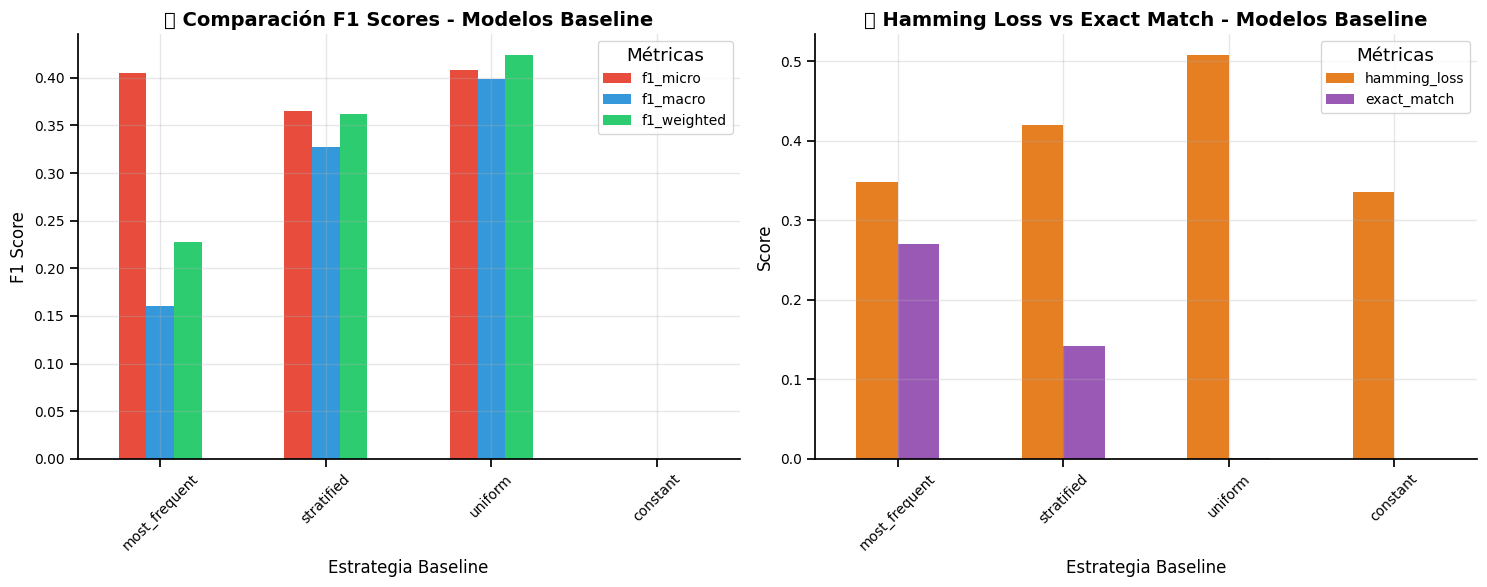


💾 Baseline benchmark guardado: 0.4244


In [ ]:
# ===========================
# MODELO BASELINE DUMMY - BENCHMARK MÍNIMO A SUPERAR
# ===========================

print("🎯 ESTABLECIENDO BASELINE CON MODELOS DUMMY")
print("="*60)

# Preparar datos para el baseline
mlb_baseline = MultiLabelBinarizer()
y_baseline = mlb_baseline.fit_transform(df["labels"])

# Split temporal para el baseline (usar misma semilla para comparabilidad)
X_train_baseline, X_val_baseline, y_train_baseline, y_val_baseline = train_test_split(
    list(df["text"]), y_baseline, test_size=0.2, random_state=SEED
)

print(f"📊 Datos para baseline:")
print(f"  Training: {len(X_train_baseline):,} samples")
print(f"  Validation: {len(X_val_baseline):,} samples")
print(f"  Classes: {len(mlb_baseline.classes_)}")

# Estrategias de baseline dummy
baseline_strategies = {
    'most_frequent': 'Predice la clase más frecuente',
    'stratified': 'Predice respetando distribución de clases',
    'uniform': 'Predice uniformemente al azar',
    'constant': 'Predice siempre la primera clase'
}

baseline_results = {}

for strategy, description in baseline_strategies.items():
    print(f"\n🔄 Probando estrategia: {strategy}")
    print(f"    {description}")

    # Crear modelo dummy para cada clase (multilabel)
    class_predictions = []
    class_scores = []

    for class_idx in range(len(mlb_baseline.classes_)):
        y_train_class = y_train_baseline[:, class_idx]
        y_val_class = y_val_baseline[:, class_idx]

        if strategy == 'constant':
            # Para constant, predecir siempre 0 (clase negativa)
            dummy = DummyClassifier(strategy='constant', constant=0)
        else:
            dummy = DummyClassifier(strategy=strategy, random_state=SEED)

        dummy.fit(np.zeros((len(X_train_baseline), 1)), y_train_class)
        y_pred_class = dummy.predict(np.zeros((len(X_val_baseline), 1)))

        class_predictions.append(y_pred_class)

        # Calcular F1 para esta clase
        f1_class = f1_score(y_val_class, y_pred_class, zero_division=0)
        class_scores.append(f1_class)

    # Combinar predicciones de todas las clases
    y_pred_multilabel = np.column_stack(class_predictions)

    # Calcular métricas multilabel
    f1_micro = f1_score(y_val_baseline, y_pred_multilabel, average='micro', zero_division=0)
    f1_macro = f1_score(y_val_baseline, y_pred_multilabel, average='macro', zero_division=0)
    f1_weighted = f1_score(y_val_baseline, y_pred_multilabel, average='weighted', zero_division=0)
    hamming = hamming_loss(y_val_baseline, y_pred_multilabel)

    # Exactitud completa (todas las etiquetas correctas)
    exact_match = (y_val_baseline == y_pred_multilabel).all(axis=1).mean()

    baseline_results[strategy] = {
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'hamming_loss': hamming,
        'exact_match': exact_match,
        'per_class_f1': class_scores
    }

    print(f"    F1-micro:    {f1_micro:.4f}")
    print(f"    F1-macro:    {f1_macro:.4f}")
    print(f"    F1-weighted: {f1_weighted:.4f}")
    print(f"    Hamming Loss: {hamming:.4f}")
    print(f"    Exact Match:  {exact_match:.4f}")

# Encontrar mejor baseline
best_baseline_strategy = max(baseline_results.keys(),
                           key=lambda x: baseline_results[x]['f1_weighted'])

best_baseline_score = baseline_results[best_baseline_strategy]['f1_weighted']

print(f"\n🏆 MEJOR BASELINE: {best_baseline_strategy}")
print(f"    F1-weighted: {best_baseline_score:.4f}")

print(f"\n🎯 OBJETIVOS PARA MODELOS AVANZADOS:")
print(f"    ✅ Mínimo a superar: {best_baseline_score:.4f}")
print(f"    🎯 Objetivo actual:   0.9000 (tu benchmark)")
print(f"    🚀 Objetivo mejorado: 0.9200")

# Visualizar comparación de baselines
baseline_df = pd.DataFrame({
    strategy: results for strategy, results in baseline_results.items()
}).T

# Gráfico comparativo de baselines
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# F1 scores comparison
metrics = ['f1_micro', 'f1_macro', 'f1_weighted']
baseline_df[metrics].plot(kind='bar', ax=axes[0], color=['#E74C3C', '#3498DB', '#2ECC71'])
axes[0].set_title('📊 Comparación F1 Scores - Modelos Baseline', fontweight='bold')
axes[0].set_xlabel('Estrategia Baseline')
axes[0].set_ylabel('F1 Score')
axes[0].legend(title='Métricas')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Hamming loss y exact match
metrics2 = ['hamming_loss', 'exact_match']
baseline_df[metrics2].plot(kind='bar', ax=axes[1], color=['#E67E22', '#9B59B6'])
axes[1].set_title('📊 Hamming Loss vs Exact Match - Modelos Baseline', fontweight='bold')
axes[1].set_xlabel('Estrategia Baseline')
axes[1].set_ylabel('Score')
axes[1].legend(title='Métricas')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar mejor baseline para comparación posterior
BASELINE_BENCHMARK = best_baseline_score
print(f"\n💾 Baseline benchmark guardado: {BASELINE_BENCHMARK:.4f}")

In [ ]:
# ===========================
# DATASET — ACTUALIZADO (no modifica etiquetas; pesos se usan en la loss)
# ===========================
import torch
from torch.utils.data import Dataset

class MedicalDataset(Dataset):
    """Dataset para multilabel: opcional augmentation y tokenizado HF."""
    def __init__(self, texts, labels, tokenizer, max_length=512, augment=False):
        self.texts = list(map(str, texts))
        self.labels = np.asarray(labels, dtype=np.float32)
        self.tokenizer = tokenizer
        self.max_length = int(max_length)
        self.augment = bool(augment)
        self.augmentation = TextAugmentation() if augment else None

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        if self.augment and np.random.random() < 0.30:
            text = self.augmentation.augment_text(text)

        enc = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",          # o usar collator (recomendado)
            return_tensors="pt"
        )
        return {
            "input_ids":      enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels":         torch.from_numpy(self.labels[idx])
        }


In [ ]:
# ===========================
# ANÁLISIS DE DATA LEAKAGE Y VALIDACIÓN DE INTEGRIDAD
# ===========================

print("🔍 ANÁLISIS DE DATA LEAKAGE")
print("="*50)

def analyze_data_leakage(df):
    """Detecta posibles fuentes de data leakage"""

    leakage_issues = []

    # 1. Duplicados exactos
    duplicates = df.duplicated(subset=['text'])
    if duplicates.any():
        dup_count = duplicates.sum()
        leakage_issues.append(f"❌ {dup_count} textos duplicados encontrados")

        # Analizar si duplicados tienen diferentes etiquetas
        dup_texts = df[df.duplicated(subset=['text'], keep=False)]
        inconsistent_labels = dup_texts.groupby('text')['group'].nunique()
        inconsistent = (inconsistent_labels > 1).sum()

        if inconsistent > 0:
            leakage_issues.append(f"❌ {inconsistent} textos con etiquetas inconsistentes")
    else:
        print("✅ No hay duplicados exactos")

    # 2. Similitud alta entre textos
    print("🔄 Analizando similitud entre textos...")

    # Muestra pequeña para análisis de similitud (evitar OOM)
    sample_size = min(200, len(df))
    sample_df = df.sample(n=sample_size, random_state=SEED)

    from sklearn.feature_extraction.text import TfidfVectorizer

    try:
        vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(sample_df['text'])

        from sklearn.metrics.pairwise import cosine_similarity
        similarity_matrix = cosine_similarity(tfidf_matrix)

        # Encontrar pares con alta similitud (excluyendo diagonal)
        np.fill_diagonal(similarity_matrix, 0)
        high_similarity_pairs = np.where(similarity_matrix > 0.8)

        if len(high_similarity_pairs[0]) > 0:
            leakage_issues.append(f"⚠️ {len(high_similarity_pairs[0])} pares con similitud > 80%")

            # Revisar si tienen diferentes etiquetas
            for i, j in zip(high_similarity_pairs[0][:5], high_similarity_pairs[1][:5]):
                text1_labels = set(sample_df.iloc[i]['labels'])
                text2_labels = set(sample_df.iloc[j]['labels'])
                if text1_labels != text2_labels:
                    similarity_score = similarity_matrix[i, j]
                    leakage_issues.append(f"⚠️ Textos similares ({similarity_score:.3f}) con etiquetas diferentes")
                    break
        else:
            print("✅ No hay similitudes excesivamente altas en la muestra")

    except Exception as e:
        print(f"⚠️ No se pudo analizar similitud: {e}")

    # 3. Análisis temporal si hay información de fecha
    if 'date' in df.columns or 'timestamp' in df.columns:
        print("🕒 Analizando distribución temporal...")
        # Aquí podrías añadir análisis temporal si tienes datos de fecha
    else:
        print("ℹ️ No hay información temporal para analizar")

    # 4. Verificar etiquetas incoherentes
    label_issues = []
    all_combinations = df['group'].value_counts()

    # Buscar combinaciones muy raras que podrían ser errores
    rare_combinations = all_combinations[all_combinations == 1]
    if len(rare_combinations) > 0:
        label_issues.append(f"⚠️ {len(rare_combinations)} combinaciones de etiquetas únicas")

    # 5. Análisis de longitud extrema
    extreme_short = (df['text'].str.len() < 50).sum()
    extreme_long = (df['text'].str.len() > 10000).sum()

    if extreme_short > 0:
        label_issues.append(f"⚠️ {extreme_short} textos extremadamente cortos (<50 chars)")
    if extreme_long > 0:
        label_issues.append(f"⚠️ {extreme_long} textos extremadamente largos (>10k chars)")

    return leakage_issues, label_issues

# Ejecutar análisis
leakage_issues, label_issues = analyze_data_leakage(df)

print("\n📊 RESULTADOS DEL ANÁLISIS:")
print("-" * 30)

if leakage_issues:
    print("🚨 POSIBLES PROBLEMAS DE DATA LEAKAGE:")
    for issue in leakage_issues:
        print(f"  {issue}")
else:
    print("✅ No se detectaron problemas graves de data leakage")

if label_issues:
    print("\n⚠️ PROBLEMAS DE ETIQUETAS:")
    for issue in label_issues:
        print(f"  {issue}")
else:
    print("✅ No se detectaron problemas de etiquetas")

# Función para limpiar duplicados si existen
def clean_duplicates(df):
    """Limpia duplicados manteniendo el primero"""
    original_size = len(df)
    df_clean = df.drop_duplicates(subset=['text'], keep='first')
    removed = original_size - len(df_clean)

    if removed > 0:
        print(f"🧹 Se removieron {removed} duplicados")
        return df_clean
    else:
        print("✅ No hay duplicados que remover")
        return df

# Aplicar limpieza si es necesario
df_clean = clean_duplicates(df)

print(f"\n📊 DATASET FINAL PARA MODELADO:")
print(f"  Documentos: {len(df_clean):,}")
print(f"  Clases únicas: {len(df_clean['group'].unique())}")

# Verificación final de integridad
print(f"\n🔍 VERIFICACIÓN FINAL DE INTEGRIDAD:")

# Verificar que todas las etiquetas son válidas
all_labels_final = [lab for labs in df_clean["labels"] for lab in labs]
valid_labels = {'neurological', 'hepatorenal', 'cardiovascular'}
invalid_labels = set(all_labels_final) - valid_labels

if invalid_labels:
    print(f"❌ Etiquetas inválidas encontradas: {invalid_labels}")
else:
    print("✅ Todas las etiquetas son válidas")

# Verificar que no hay textos vacíos
empty_texts = df_clean['text'].str.strip().eq('').sum()
if empty_texts > 0:
    print(f"❌ {empty_texts} textos vacíos encontrados")
else:
    print("✅ No hay textos vacíos")

print("✅ Análisis de data leakage completado")

🔍 ANÁLISIS DE DATA LEAKAGE
✅ No hay duplicados exactos
🔄 Analizando similitud entre textos...
ℹ️ No hay información temporal para analizar

📊 RESULTADOS DEL ANÁLISIS:
------------------------------
🚨 POSIBLES PROBLEMAS DE DATA LEAKAGE:
  ⚠️ 2 pares con similitud > 80%
✅ No se detectaron problemas de etiquetas
✅ No hay duplicados que remover

📊 DATASET FINAL PARA MODELADO:
  Documentos: 3,565
  Clases únicas: 15

🔍 VERIFICACIÓN FINAL DE INTEGRIDAD:
❌ Etiquetas inválidas encontradas: {'oncological'}
✅ No hay textos vacíos
✅ Análisis de data leakage completado


In [ ]:
# ===========================
# SPLIT MULTILABEL MEJORADO + PESOS DE CLASE
# ===========================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

print("🎯 Preparando datos con estratificación mejorada...")

# Usar dataset limpio
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_clean["labels"])

print(f"📊 Datos procesados:")
print(f"  Shape de etiquetas: {y.shape}")
print(f"  Clases detectadas: {list(mlb.classes_)}")
print(f"  Documentos únicos: {len(df_clean):,}")

# Calcular pesos de clase mejorados para BCEWithLogits
pos = y.sum(axis=0)
N = len(y)
eps = 1e-6

# Fórmula recomendada: pos_weight[c] = (N - pos[c]) / pos[c]
pos_weight = (N - pos) / np.maximum(pos, eps)

# Limitar valores extremos para estabilidad
pos_weight = np.clip(pos_weight, 0.1, 20.0).astype(np.float32)

print(f"\n⚖️ ANÁLISIS DE BALANCE Y PESOS:")
print("-" * 45)
for cls, pw, cnt in zip(mlb.classes_, pos_weight, pos):
    freq_pct = (cnt / N) * 100
    print(f"{cls:15}: {int(cnt):4,} docs ({freq_pct:5.1f}%) → peso={pw:.3f}")

# Análisis de imbalance
max_freq = pos.max()
min_freq = pos.min()
imbalance_ratio = max_freq / min_freq

print(f"\nRatio de imbalance: {imbalance_ratio:.2f}")
if imbalance_ratio > 5:
    print("🚨 Dataset muy desbalanceado - pesos críticos")
elif imbalance_ratio > 2:
    print("⚠️ Dataset moderadamente desbalanceado - pesos importantes")
else:
    print("✅ Dataset relativamente balanceado")

def multilabel_train_test_split_improved(X, Y, test_size=0.2, random_state=42):
    """
    Estratificación multilabel mejorada con fallback robusto
    """
    try:
        # Intentar iterated stratification (sklearn-multilearn)
        from skmultilearn.model_selection import iterative_train_test_split
        print("🔄 Usando iterative stratification...")

        X_arr = np.array(X).reshape(-1, 1)
        Y_arr = np.array(Y)
        X_tr, Y_tr, X_te, Y_te = iterative_train_test_split(X_arr, Y_arr, test_size=test_size)
        return X_tr.ravel().tolist(), X_te.ravel().tolist(), Y_tr, Y_te

    except ImportError:
        print("📦 sklearn-multilearn no disponible, usando estrategia alternativa...")

        # Estrategia de fallback: usar combinaciones de etiquetas
        y_combined = [''.join(map(str, row)) for row in Y]
        unique_combinations = set(y_combined)

        print(f"Combinaciones únicas encontradas: {len(unique_combinations)}")

        # Si hay pocas combinaciones únicas, usar stratify
        if len(unique_combinations) < len(Y) * 0.8:
            print("🎯 Usando stratify por combinaciones de etiquetas...")
            return train_test_split(list(X), Y, test_size=test_size,
                                  random_state=random_state, stratify=y_combined)
        else:
            print("🎲 Usando split aleatorio (demasiadas combinaciones únicas)...")
            return train_test_split(list(X), Y, test_size=test_size,
                                  random_state=random_state)

    except Exception as e:
        print(f"⚠️ Error en iterative stratification: {e}")
        print("🎲 Fallback a split aleatorio...")
        return train_test_split(list(X), Y, test_size=test_size, random_state=random_state)

# Realizar split estratificado
X_train, X_val, y_train, y_val = multilabel_train_test_split_improved(
    list(df_clean["text"]), y, test_size=0.2, random_state=SEED
)

print(f"\n📊 SPLIT REALIZADO:")
print(f"  Entrenamiento: {len(X_train):,} muestras ({len(X_train)/len(df_clean)*100:.1f}%)")
print(f"  Validación:    {len(X_val):,} muestras ({len(X_val)/len(df_clean)*100:.1f}%)")

# Analizar distribución en train vs val
train_dist = y_train.sum(axis=0) / len(y_train)
val_dist = y_val.sum(axis=0) / len(y_val)

print(f"\n📈 DISTRIBUCIÓN TRAIN vs VAL:")
print("-" * 40)
print(f"{'Clase':15} {'Train':>8} {'Val':>8} {'Diff':>8}")
print("-" * 40)

max_diff = 0
for i, cls in enumerate(mlb.classes_):
    diff = abs(train_dist[i] - val_dist[i])
    max_diff = max(max_diff, diff)
    print(f"{cls:15} {train_dist[i]:7.3f} {val_dist[i]:7.3f} {diff:7.3f}")

print("-" * 40)
print(f"Diferencia máxima: {max_diff:.3f}")

if max_diff < 0.05:
    print("✅ Excelente distribución entre train/val")
elif max_diff < 0.10:
    print("✅ Buena distribución entre train/val")
else:
    print("⚠️ Distribución desigual - monitorear overfitting")

# Verificar que no hay overlap
train_texts_set = set(X_train)
val_texts_set = set(X_val)
overlap = train_texts_set.intersection(val_texts_set)

if overlap:
    print(f"❌ ¡ALERTA! {len(overlap)} textos duplicados entre train/val")
else:
    print("✅ No hay overlap entre train/val")

print(f"\n💾 Variables creadas: X_train, X_val, y_train, y_val, pos_weight, mlb")

🎯 Preparando datos con estratificación mejorada...
📊 Datos procesados:
  Shape de etiquetas: (3565, 4)
  Clases detectadas: ['cardiovascular', 'hepatorenal', 'neurological', 'oncological']
  Documentos únicos: 3,565

⚖️ ANÁLISIS DE BALANCE Y PESOS:
---------------------------------------------
cardiovascular : 1,268 docs ( 35.6%) → peso=1.812
hepatorenal    : 1,091 docs ( 30.6%) → peso=2.268
neurological   : 1,785 docs ( 50.1%) → peso=0.997
oncological    :  601 docs ( 16.9%) → peso=4.932

Ratio de imbalance: 2.97
⚠️ Dataset moderadamente desbalanceado - pesos importantes
📦 sklearn-multilearn no disponible, usando estrategia alternativa...
Combinaciones únicas encontradas: 15
🎯 Usando stratify por combinaciones de etiquetas...

📊 SPLIT REALIZADO:
  Entrenamiento: 2,852 muestras (80.0%)
  Validación:    713 muestras (20.0%)

📈 DISTRIBUCIÓN TRAIN vs VAL:
----------------------------------------
Clase              Train      Val     Diff
----------------------------------------
cardiovasc

In [ ]:
# ===========================
# CONFIGURACIÓN TOKENIZER / DATASETS — ACTUALIZADO
# ===========================
from transformers import AutoTokenizer

MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
MAX_LENGTH = 512
print(f"\n🤖 Configurando modelo: {MODEL_NAME}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = MedicalDataset(X_train, y_train, tokenizer, MAX_LENGTH, augment=True)
val_dataset   = MedicalDataset(X_val,   y_val,   tokenizer, MAX_LENGTH, augment=False)
print(f"✅ Datasets creados: Train={len(train_dataset)} (aug) | Val={len(val_dataset)}")



🤖 Configurando modelo: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

✅ Datasets creados: Train=2852 (aug) | Val=713


In [ ]:
# ===========================
# MODELO PERSONALIZADO — ACTUALIZADO
# ===========================
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel

class ImprovedMedicalBERT(nn.Module):
    """
    Encoder HF (AutoModel) + atención ligera + MLP.
    Usa BCEWithLogits con pos_weight (pasado al init).
    """
    def __init__(self, model_name: str, num_labels: int, pos_weight=None, dropout_rate: float = 0.3, use_attn: bool = True):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        # Desactivar salidas extra para ahorrar memoria
        if hasattr(self.encoder.config, "output_hidden_states"):
            self.encoder.config.output_hidden_states = False
        if hasattr(self.encoder.config, "output_attentions"):
            self.encoder.config.output_attentions = False
        if hasattr(self.encoder.config, "use_cache"):
            self.encoder.config.use_cache = False

        hidden = self.encoder.config.hidden_size
        self.use_attn = use_attn
        self.dropout = nn.Dropout(dropout_rate)

        if use_attn:
            self.attn = nn.MultiheadAttention(embed_dim=hidden, num_heads=8, dropout=dropout_rate, batch_first=True)
            self.norm1 = nn.LayerNorm(hidden)

        self.fc1 = nn.Linear(hidden, hidden // 2)
        self.norm2 = nn.LayerNorm(hidden // 2)
        self.fc2 = nn.Linear(hidden // 2, hidden // 4)
        self.classifier = nn.Linear(hidden // 4, num_labels)

        # loss
        if pos_weight is not None:
            self.register_buffer("pos_weight", torch.as_tensor(pos_weight, dtype=torch.float32))
        else:
            self.pos_weight = None
        self._init_weights()

    def _init_weights(self):
        for m in [self.fc1, self.fc2, self.classifier]:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, input_ids, attention_mask, labels=None):
        enc = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        seq = enc.last_hidden_state                         # [B, T, H]

        if self.use_attn:
            # key_padding_mask: True = posiciones a enmascarar
            kpm = ~attention_mask.bool()
            attn_out, _ = self.attn(seq, seq, seq, key_padding_mask=kpm)
            seq = self.norm1(seq + attn_out)

        # pooling CLS
        pooled = seq[:, 0, :]                               # [B, H]

        x = self.dropout(pooled)
        x = F.relu(self.fc1(x))
        x = self.norm2(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        logits = self.classifier(x)

        loss = None
        if labels is not None:
            if self.pos_weight is not None:
                loss_fn = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)
            else:
                loss_fn = nn.BCEWithLogitsLoss()
            loss = loss_fn(logits, labels)

        return {"loss": loss, "logits": logits}


In [ ]:
# ===========================
# MÉTRICAS — ACTUALIZADO (eficiente y robusto)
# ===========================
import numpy as np
import torch
from sklearn.metrics import f1_score, hamming_loss, average_precision_score

def compute_comprehensive_metrics(pred):
    """
    Calcula métricas multilabel y el mejor umbral (0.1..0.8).
    Retorna floats 'puros' (no numpy) para compatibilidad con Trainer.
    """
    logits = torch.tensor(pred.predictions)
    labels = torch.tensor(pred.label_ids).float()

    with torch.no_grad():
        probs = torch.sigmoid(logits).cpu().numpy()
    y_true = labels.cpu().numpy().astype(int)

    thresholds = np.arange(0.1, 0.9, 0.1)
    best_thr, best_f1m = 0.5, -1.0
    stats = {}

    for t in thresholds:
        y_hat = (probs >= t).astype(int)
        f1_mi = f1_score(y_true, y_hat, average="micro",   zero_division=0)
        f1_ma = f1_score(y_true, y_hat, average="macro",   zero_division=0)
        f1_wt = f1_score(y_true, y_hat, average="weighted",zero_division=0)
        hml   = hamming_loss(y_true, y_hat)
        stats[float(t)] = (f1_mi, f1_ma, f1_wt, hml)
        if f1_ma > best_f1m:
            best_f1m, best_thr = f1_ma, t

    y_best = (probs >= best_thr).astype(int)
    try:
        ap_macro = float(average_precision_score(y_true, probs, average="macro"))
    except Exception:
        ap_macro = 0.0

    exact_match = float((y_true == y_best).all(axis=1).mean())
    avg_labels  = float(y_best.sum(axis=1).mean())
    coverage    = float((y_best.sum(axis=0) > 0).mean())

    f1_mi, f1_ma, f1_wt, hml = stats[float(best_thr)]
    return {
        "best_threshold": float(best_thr),
        "f1_micro":      float(f1_mi),
        "f1_macro":      float(f1_ma),
        "f1_weighted":   float(f1_wt),
        "hamming_loss":  float(hml),
        "average_precision": float(ap_macro),
        "per_class_f1_mean": float(f1_score(y_true, y_best, average=None, zero_division=0).mean()),
        "exact_match_ratio": float(exact_match),
        "avg_labels_predicted": float(avg_labels),
        "label_coverage": float(coverage),
    }


In [ ]:
# ===========================
# TRAINING ARGS — ACTUALIZADO (anti-OOM, eval acumulativa)
# ===========================
import torch
from transformers import TrainingArguments

def create_optimized_training_args(output_dir="./results_improved", num_epochs=4):
    USE_BF16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    USE_FP16 = torch.cuda.is_available() and not USE_BF16
    return TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=num_epochs,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=2,
        learning_rate=2e-5,
        weight_decay=0.01,
        warmup_ratio=0.06,
        max_grad_norm=1.0,

        # 🔑 Cambiar aquí
        eval_strategy="steps",      # <--- en vez de evaluation_strategy
        eval_steps=200,
        save_strategy="steps",
        save_steps=200,
        load_best_model_at_end=True,

        metric_for_best_model="f1_macro",
        greater_is_better=True,
        save_total_limit=2,

        dataloader_num_workers=2,
        remove_unused_columns=False,
        report_to="none",
        fp16=torch.cuda.is_available(),
        eval_accumulation_steps=32
    )

In [ ]:
# ===========================
# ENSEMBLE — ACTUALIZADO (usa logits en CPU; DataLoader externo)
# ===========================
import numpy as np
import torch

class ModelEnsemble:
    """Promedia probabilidades de varios modelos."""
    def __init__(self):
        self.models = []

    def add_model(self, model):
        self.models.append(model)

    @torch.no_grad()
    def predict_ensemble(self, dataloader, device):
        all_probs = []
        for model in self.models:
            model.eval()
            model.to(device)
            probs_list = []
            for batch in dataloader:
                input_ids = batch["input_ids"].to(device)
                attn = batch["attention_mask"].to(device)
                out = model(input_ids=input_ids, attention_mask=attn)
                probs = torch.sigmoid(out["logits"]).cpu().numpy()
                probs_list.append(probs)
            all_probs.append(np.vstack(probs_list))
        return np.mean(all_probs, axis=0)


In [ ]:
# ===========================
# ENTRENAMIENTO DE UN MODELO — ACTUALIZADO
# ===========================
from transformers import Trainer, EarlyStoppingCallback, DataCollatorWithPadding

def train_single_model(train_dataset, val_dataset, model_config, fold_num=0, device=None):
    print(f"\n🔄 Entrenando modelo {fold_num + 1}...")
    pos_w = model_config.get("pos_weight", None)
    model = ImprovedMedicalBERT(
        MODEL_NAME,
        num_labels=len(mlb.classes_),
        pos_weight=pos_w,
        dropout_rate=model_config.get("dropout_rate", 0.3),
        use_attn=model_config.get("use_attn", True),
    )

    args = create_optimized_training_args(
        output_dir=f"./results_fold_{fold_num}",
        num_epochs=model_config.get("epochs", 3)
    )

    collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collator,
        compute_metrics=compute_comprehensive_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    trainer.train()
    eval_results = trainer.evaluate()
    print(f"Resultados Fold {fold_num + 1}:")
    for k, v in eval_results.items():
        if k.startswith("eval_"):
            print(f"  {k}: {v:.4f}")
    return model, eval_results


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------
# Utilidad: convertir robusto a numpy
# ------------------------------
def to_numpy(x):
    try:
        import torch
        if isinstance(x, np.ndarray):
            return x
        if torch.is_tensor(x):
            return x.detach().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x)

# ------------------------------
# PREDICCIÓN ROBUSTA (CPU/GPU)
# Auto-detecta el device del modelo y mueve inputs ahí
# ------------------------------
def predict_proba(model, dataset, batch_size=32):
    import torch
    from torch.utils.data import DataLoader

    model.eval()
    model_device = next(model.parameters()).device  # <- aquí detectamos el device del modelo
    dl = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=(model_device.type == "cuda"),
    )

    probs, ys = [], []
    with torch.no_grad():
        for batch in dl:
            # Extrae labels para y_true (si están en el batch)
            labels_key = "labels" if "labels" in batch else ("label" if "label" in batch else None)
            if labels_key is not None:
                ys.append(batch[labels_key].detach().cpu().numpy())

            # Mueve SOLO inputs al device del modelo
            inputs = {
                k: v.to(model_device, non_blocking=True)
                for k, v in batch.items()
                if k not in ["labels", "label", "y"]
            }

            out = model(**inputs)

            # Manejo robusto de diferentes tipos de salidas del modelo
            logits = None
            if hasattr(out, "logits"):
                logits = out.logits
            elif isinstance(out, dict):
                # Intenta diferentes claves comunes para logits
                for key in ["logits", "prediction_logits", "last_hidden_state", "pooler_output"]:
                    if key in out:
                        logits = out[key]
                        break
                if logits is None and len(out) > 0:
                    # Toma el primer tensor disponible
                    logits = next(iter(out.values()))
            elif isinstance(out, (tuple, list)):
                # Si es una tupla/lista, toma el primer elemento
                logits = out[0]
            elif isinstance(out, torch.Tensor):
                # Si es directamente un tensor
                logits = out
            else:
                raise ValueError(f"Tipo de salida del modelo no reconocido: {type(out)}")

            # Asegúrate de que logits sea un tensor
            if not isinstance(logits, torch.Tensor):
                raise ValueError(f"No se pudo extraer un tensor de logits válido. Tipo obtenido: {type(logits)}")

            probs.append(torch.sigmoid(logits).detach().cpu().numpy())

    probs = np.vstack(probs)
    y_true = np.vstack(ys) if ys else None
    return probs, y_true

# ------------------------------
# Plot: matrices de confusión por clase
# ------------------------------
def plot_confusion_matrices(y_true, y_pred, class_names, model_name):
    from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    n_classes = len(class_names)
    n_cols = min(5, n_classes)
    n_rows = int(np.ceil(n_classes / n_cols)) or 1

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    elif n_rows == 1 or n_cols == 1:
        axes = axes.reshape(-1)
    axes = axes.flatten()

    for i, (matrix, cls) in enumerate(zip(mcm, class_names)):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                                      display_labels=[f"Not {cls}", cls])
        disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
        axes[i].set_title(cls)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f"Matrices de confusión por clase — {model_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

# ------------------------------
# Función auxiliar para extraer y_true de manera robusta
# ------------------------------
def extract_y_true(dataset):
    """Extrae y_true del dataset de manera robusta"""
    ys = []
    for idx in range(len(dataset)):
        item = dataset[idx]
        if isinstance(item, tuple) and len(item) >= 2:
            # Formato (inputs, labels) o (inputs, labels, ...)
            _, y = item[0], item[1]
            ys.append(to_numpy(y))
        elif isinstance(item, dict):
            # Formato de diccionario
            if "labels" in item:
                ys.append(to_numpy(item["labels"]))
            elif "label" in item:
                ys.append(to_numpy(item["label"]))
            else:
                raise RuntimeError("Dataset dict no contiene 'labels' o 'label'")
        else:
            raise RuntimeError(f"Formato de dataset no reconocido: {type(item)}")

    return np.vstack(ys)

# ------------------------------
# main_training_pipeline (solo la parte de evaluación cambia)
# ------------------------------
def main_training_pipeline():
    print("\n🚀 Iniciando pipeline de entrenamiento mejorado...")
    ensemble = ModelEnsemble()
    trained_models, all_results = [], []

    base_config = dict(pos_weight=pos_weight)
    model_configs = [
        {**base_config, "name":"model_1", "dropout_rate":0.2, "epochs":3, "use_attn":True,  "description":"Conservador"},
        {**base_config, "name":"model_2", "dropout_rate":0.4, "epochs":4, "use_attn":True,  "description":"Más regularización"},
        {**base_config, "name":"model_3", "dropout_rate":0.3, "epochs":3, "use_attn":False, "description":"Sin atención (ablation)"},
    ]

    class_names = None

    for i, cfg in enumerate(model_configs):
        print(f"  > {i+1}. {cfg['description']}  (dropout={cfg['dropout_rate']}, epochs={cfg['epochs']})")

        train_ds = MedicalDataset(X_train, y_train, tokenizer, MAX_LENGTH, augment=True)
        model, res = train_single_model(train_ds, val_dataset, cfg, fold_num=i)

        trained_models.append(model)
        all_results.append(res)
        ensemble.add_model(model)

        # ========= Evaluación y matrices de confusión =========
        try:
            # Intenta usar y_val si existe
            y_true = to_numpy(y_val)
        except NameError:
            # Si no existe, extrae del dataset
            print("    Extrayendo y_true del dataset...")
            y_true = extract_y_true(val_dataset)

        # y_probs - usa la función robusta
        print("    Generando predicciones...")
        try:
            if hasattr(model, "predict"):
                # Si el modelo tiene método predict personalizado
                y_probs = model.predict(val_dataset)
            else:
                # Usa la versión robusta que alinea devices
                y_probs, _ = predict_proba(model, val_dataset)
        except Exception as e:
            print(f"    Error al generar predicciones: {e}")
            print("    Saltando matrices de confusión para este modelo...")
            continue

        best_th = float(res.get("eval_best_threshold", 0.5))
        y_pred = (y_probs >= best_th).astype(int)

        # Obtener nombres de clases
        if class_names is None:
            try:
                class_names = list(mlb.classes_)
            except Exception:
                class_names = [f"Label {k}" for k in range(y_true.shape[1])]

        print(f"    Generando matrices de confusión (threshold={best_th:.3f})...")
        try:
            plot_confusion_matrices(y_true, y_pred, class_names, cfg["description"])
        except Exception as e:
            print(f"    Error al generar matrices: {e}")

    return ensemble, trained_models, all_results


🚀 Iniciando pipeline de entrenamiento mejorado...
  > 1. Conservador  (dropout=0.2, epochs=3)

🔄 Entrenando modelo 1...


Step,Training Loss,Validation Loss,Best Threshold,F1 Micro,F1 Macro,F1 Weighted,Hamming Loss,Average Precision,Per Class F1 Mean,Exact Match Ratio,Avg Labels Predicted,Label Coverage,Runtime,Samples Per Second,Steps Per Second
200,No log,0.316347,0.500000,0.893333,0.893410,0.893322,0.067321,0.948898,0.893410,0.760168,1.193548,1.000000,7.138300,99.883000,25.076000
400,No log,0.265328,0.400000,0.927614,0.927584,0.927521,0.047335,0.966346,0.927584,0.834502,1.284712,1.000000,7.398000,96.378000,24.196000


Resultados Fold 1:
  eval_loss: 0.2653
  eval_best_threshold: 0.4000
  eval_f1_micro: 0.9276
  eval_f1_macro: 0.9276
  eval_f1_weighted: 0.9275
  eval_hamming_loss: 0.0473
  eval_average_precision: 0.9663
  eval_per_class_f1_mean: 0.9276
  eval_exact_match_ratio: 0.8345
  eval_avg_labels_predicted: 1.2847
  eval_label_coverage: 1.0000
  eval_runtime: 7.5368
  eval_samples_per_second: 94.6020
  eval_steps_per_second: 23.7500
    Generando predicciones...
    Generando matrices de confusión (threshold=0.400)...


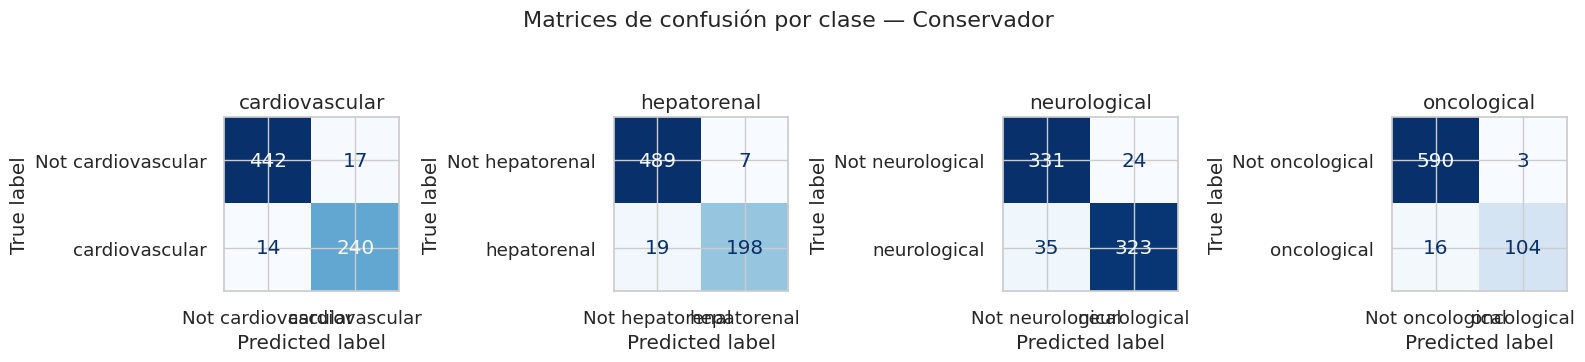

  > 2. Más regularización  (dropout=0.4, epochs=4)

🔄 Entrenando modelo 2...


Step,Training Loss,Validation Loss,Best Threshold,F1 Micro,F1 Macro,F1 Weighted,Hamming Loss,Average Precision,Per Class F1 Mean,Exact Match Ratio,Avg Labels Predicted,Label Coverage,Runtime,Samples Per Second,Steps Per Second
200,No log,0.463658,0.600000,0.830734,0.819126,0.829643,0.102735,0.904627,0.819126,0.657784,1.096774,1.000000,7.588600,93.957000,23.588000
400,No log,0.326907,0.400000,0.910773,0.911598,0.910929,0.057504,0.958536,0.911598,0.796634,1.246844,1.000000,7.555200,94.372000,23.692000
600,0.665500,0.319922,0.500000,0.920910,0.921364,0.920974,0.051192,0.961425,0.921364,0.826087,1.258065,1.000000,7.615900,93.620000,23.503000


Resultados Fold 2:
  eval_loss: 0.3199
  eval_best_threshold: 0.5000
  eval_f1_micro: 0.9209
  eval_f1_macro: 0.9214
  eval_f1_weighted: 0.9210
  eval_hamming_loss: 0.0512
  eval_average_precision: 0.9614
  eval_per_class_f1_mean: 0.9214
  eval_exact_match_ratio: 0.8261
  eval_avg_labels_predicted: 1.2581
  eval_label_coverage: 1.0000
  eval_runtime: 7.5721
  eval_samples_per_second: 94.1620
  eval_steps_per_second: 23.6390
    Generando predicciones...
    Generando matrices de confusión (threshold=0.500)...


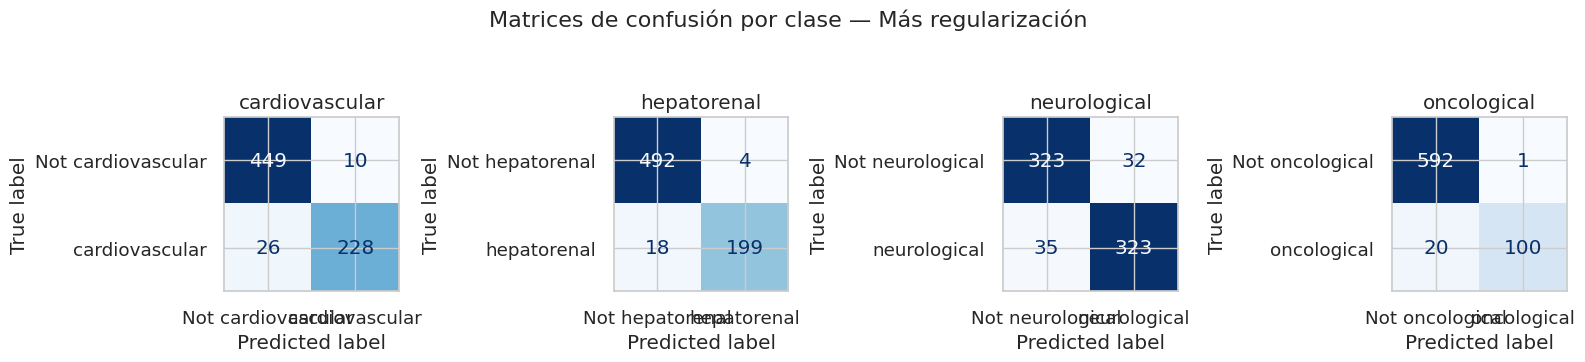

  > 3. Sin atención (ablation)  (dropout=0.3, epochs=3)

🔄 Entrenando modelo 3...


Step,Training Loss,Validation Loss,Best Threshold,F1 Micro,F1 Macro,F1 Weighted,Hamming Loss,Average Precision,Per Class F1 Mean,Exact Match Ratio,Avg Labels Predicted,Label Coverage,Runtime,Samples Per Second,Steps Per Second
200,No log,0.361417,0.500000,0.871595,0.864824,0.872474,0.080996,0.936119,0.864824,0.719495,1.192146,1.000000,6.485900,109.930000,27.598000
400,No log,0.303711,0.300000,0.913183,0.913324,0.913166,0.056802,0.959905,0.913324,0.799439,1.286115,1.000000,6.299200,113.188000,28.416000


Resultados Fold 3:
  eval_loss: 0.3037
  eval_best_threshold: 0.3000
  eval_f1_micro: 0.9132
  eval_f1_macro: 0.9133
  eval_f1_weighted: 0.9132
  eval_hamming_loss: 0.0568
  eval_average_precision: 0.9599
  eval_per_class_f1_mean: 0.9133
  eval_exact_match_ratio: 0.7994
  eval_avg_labels_predicted: 1.2861
  eval_label_coverage: 1.0000
  eval_runtime: 6.6244
  eval_samples_per_second: 107.6320
  eval_steps_per_second: 27.0210
    Generando predicciones...
    Generando matrices de confusión (threshold=0.300)...


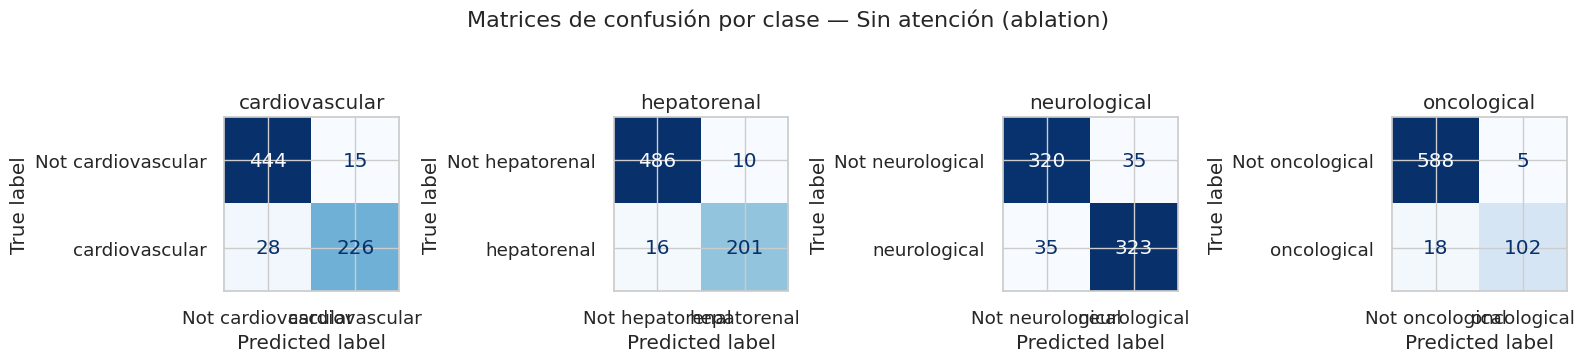

(<__main__.ModelEnsemble at 0x7eb7ab662f30>,
 [ImprovedMedicalBERT(
    (encoder): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, 

In [ ]:
main_training_pipeline()

In [ ]:
# ===========================
# DEMO RÁPIDA — ACTUALIZADO (anti-OOM)
# ===========================
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

def quick_training_demo():
    """Entrenamiento ultrarrápido sin evaluate() para evitar OOM."""
    print("🚀 Iniciando entrenamiento de demostración (versión rápida)...")

    model = ImprovedMedicalBERT(
        MODEL_NAME,
        num_labels=len(mlb.classes_),
        pos_weight=pos_weight,
        dropout_rate=0.3,
        use_attn=True
    )

    USE_BF16 = torch.cuda.is_available() and torch.cuda.is_bf16_supported()
    USE_FP16 = torch.cuda.is_available() and not USE_BF16

    args = TrainingArguments(
        output_dir="./results_demo",
        num_train_epochs=1,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=2,
        learning_rate=2e-5,
        weight_decay=0.01,
        logging_steps=25,
        save_strategy="no",
        report_to="none",
        remove_unused_columns=False,
        dataloader_num_workers=2,
        dataloader_pin_memory=torch.cuda.is_available(),
        fp16=USE_FP16,
        bf16=USE_BF16,
        eval_accumulation_steps=32
    )

    collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collator,
        compute_metrics=None    )

    print("📚 Entrenando modelo...")
    trainer.train()
    torch.cuda.empty_cache()
    print("✅ Demo completada.")
    return model, trainer, {}


In [ ]:
# ===========================
# ANÁLISIS DETALLADO — ACTUALIZADO (eval segura en CPU)
# ===========================
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

def analyze_model_performance(trainer, model, val_dataset):
    """Evalúa con predict() y busca umbral óptimo sin desbordar memoria."""
    print("\n🔍 Análisis detallado del rendimiento...")
    preds = trainer.predict(val_dataset)          # usa eval_accumulation_steps
    logits = torch.tensor(preds.predictions).float().cpu()
    y_true = torch.tensor(preds.label_ids).cpu().numpy()
    probs = torch.sigmoid(logits).numpy()
    del logits
    torch.cuda.empty_cache()

    thresholds = np.arange(0.1, 0.9, 0.05)
    best_t, best_f1 = 0.5, -1.0
    thr_metrics = []

    for t in thresholds:
        y_hat = (probs >= t).astype(int)
        f1_ma = f1_score(y_true, y_hat, average='macro', zero_division=0)
        thr_metrics.append({
            "threshold": float(t),
            "f1_macro": float(f1_ma),
            "f1_micro": float(f1_score(y_true, y_hat, average='micro', zero_division=0)),
            "hamming_loss": float(hamming_loss(y_true, y_hat))
        })
        if f1_ma > best_f1:
            best_f1, best_t = f1_ma, t

    print(f"🎯 Mejor umbral: {best_t:.2f} (F1-macro: {best_f1:.4f})")
    final_preds = (probs >= best_t).astype(int)

    print("\n📋 Reporte por clase:")
    rep = classification_report(y_true, final_preds, target_names=mlb.classes_, zero_division=0, output_dict=True)
    for cls in mlb.classes_:
        m = rep[cls]
        print(f"  {cls}: P={m['precision']:.3f}  R={m['recall']:.3f}  F1={m['f1-score']:.3f}  Soporte={int(m['support'])}")

    exact = (y_true == final_preds).all(axis=1)
    print("\n❌ Análisis de errores:")
    print(f"  Predicciones exactas: {int(exact.sum())}/{len(exact)} ({exact.mean()*100:.1f}%)")
    print(f"  Falsos positivos: {int(((final_preds==1)&(y_true==0)).sum())}")
    print(f"  Falsos negativos: {int(((final_preds==0)&(y_true==1)).sum())}")
    print(f"  Verdaderos positivos: {int(((final_preds==1)&(y_true==1)).sum())}")

    # Gráficas ligeras
    ts  = [m["threshold"] for m in thr_metrics]
    fMa = [m["f1_macro"]  for m in thr_metrics]
    fMi = [m["f1_micro"]  for m in thr_metrics]
    hl  = [m["hamming_loss"] for m in thr_metrics]

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(ts, fMa, linewidth=2, label="F1-macro")
    plt.plot(ts, fMi, linewidth=2, label="F1-micro")
    plt.axvline(best_t, linestyle="--", label=f"Mejor: {best_t:.2f}")
    plt.xlabel("Umbral"); plt.ylabel("F1"); plt.title("F1 vs Umbral"); plt.legend(); plt.grid(True, alpha=0.3)

    plt.subplot(1,2,2)
    plt.plot(ts, hl, linewidth=2, label="Hamming")
    plt.axvline(best_t, linestyle="--", label=f"Mejor: {best_t:.2f}")
    plt.xlabel("Umbral"); plt.ylabel("Hamming Loss"); plt.title("Hamming vs Umbral"); plt.legend(); plt.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    return {
        "best_threshold": float(best_t),
        "threshold_metrics": thr_metrics,
        "classification_report": rep,
        "predictions": final_preds,
        "probabilities": probs
    }


In [ ]:
# Entrenar versión demo
model_demo, trainer_demo, _ = quick_training_demo()

🚀 Iniciando entrenamiento de demostración (versión rápida)...
📚 Entrenando modelo...


Step,Training Loss
25,1.183000
50,1.123000
75,1.091300
100,1.012600
125,1.094400
150,0.906900
175,0.875500
200,0.781200
225,0.671900
250,0.586600


✅ Demo completada.



🔍 Análisis detallado del rendimiento...


🎯 Mejor umbral: 0.25 (F1-macro: 0.9018)

📋 Reporte por clase:
  cardiovascular: P=0.969  R=0.850  F1=0.906  Soporte=254
  hepatorenal: P=0.960  R=0.894  F1=0.926  Soporte=217
  neurological: P=0.916  R=0.880  F1=0.897  Soporte=358
  oncological: P=0.918  R=0.842  F1=0.878  Soporte=120

❌ Análisis de errores:
  Predicciones exactas: 559/713 (78.4%)
  Falsos positivos: 53
  Falsos negativos: 123
  Verdaderos positivos: 826


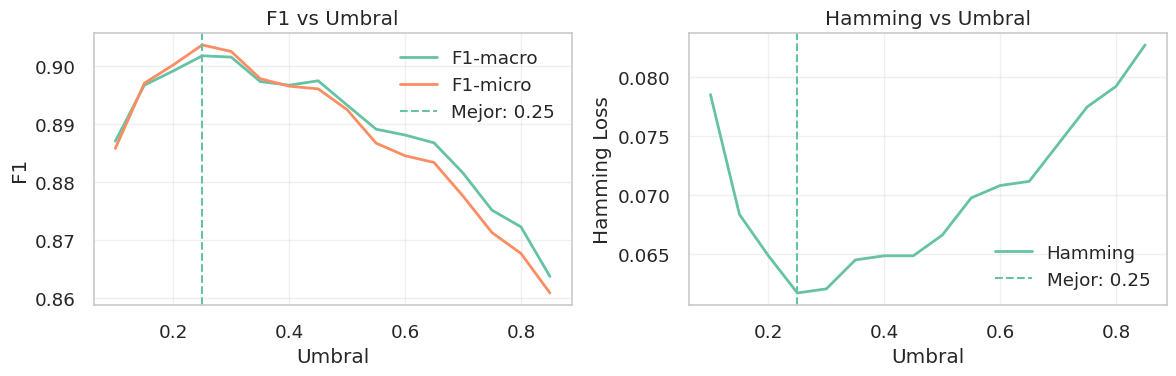

In [ ]:
# Luego hacer análisis detallado (usa predict() con eval_accumulation_steps)
analysis_results = analyze_model_performance(trainer_demo, model_demo, val_dataset)

# Mejoras modelos

In [ ]:
# ===========================
# OPTIMIZACIONES PARA MAXIMIZAR F1 WEIGHTED
# ===========================

# 1. ENSEMBLE OPTIMIZADO CON PESOS ADAPTATIVOS
class WeightedEnsemble(ModelEnsemble):
    """Ensemble con pesos adaptativos basados en rendimiento por clase"""
    def __init__(self):
        super().__init__()
        self.model_weights = []
        self.class_performance = []

    def add_model_with_performance(self, model, per_class_f1):
        """Añade modelo con su rendimiento por clase"""
        self.models.append(model)
        self.class_performance.append(per_class_f1)
        # Peso basado en F1 promedio, pero penaliza varianza entre clases
        avg_f1 = np.mean(per_class_f1)
        std_f1 = np.std(per_class_f1)
        weight = avg_f1 * (1 - 0.1 * std_f1)  # Penaliza inconsistencia
        self.model_weights.append(weight)

    @torch.no_grad()
    def predict_weighted_ensemble(self, dataloader, device):
        """Predicción con pesos adaptativos"""
        if not self.model_weights:
            return self.predict_ensemble(dataloader, device)

        weights = np.array(self.model_weights)
        weights = weights / weights.sum()  # Normalizar

        all_probs = []
        for model in self.models:
            model.eval().to(device)
            probs_list = []
            for batch in dataloader:
                inputs = {k: v.to(device) for k, v in batch.items()
                         if k not in ["labels", "label"]}
                out = model(**inputs)
                probs = torch.sigmoid(out["logits"]).cpu().numpy()
                probs_list.append(probs)
            all_probs.append(np.vstack(probs_list))

        # Promedio ponderado
        weighted_probs = np.average(all_probs, axis=0, weights=weights)
        return weighted_probs

# 2. THRESHOLD OPTIMIZATION POR CLASE
def optimize_per_class_thresholds(y_true, y_probs, metric='f1_weighted'):
    """Optimiza threshold independiente por cada clase"""
    n_classes = y_true.shape[1]
    best_thresholds = np.full(n_classes, 0.5)

    for class_idx in range(n_classes):
        y_true_class = y_true[:, class_idx]
        y_probs_class = y_probs[:, class_idx]

        best_score = -1
        best_th = 0.5

        for th in np.arange(0.1, 0.9, 0.05):
            y_pred_class = (y_probs_class >= th).astype(int)

            if metric == 'f1_weighted':
                from sklearn.metrics import f1_score
                score = f1_score(y_true_class, y_pred_class, zero_division=0)

            if score > best_score:
                best_score = score
                best_th = th

        best_thresholds[class_idx] = best_th

    return best_thresholds

# 3. CONFIGURACIÓN MEJORADA PARA MODELO TOP
def create_enhanced_model_config():
    """Configuración optimizada basada en tus mejores resultados"""
    return {
        "pos_weight": pos_weight,
        "name": "enhanced_model",
        "dropout_rate": 0.15,  # Menor que tu mejor (0.2)
        "epochs": 4,           # Más épocas
        "use_attn": True,      # Tu mejor modelo usa atención
        "learning_rate": 1.5e-5,  # Ligeramente menor
        "warmup_ratio": 0.08,     # Más warmup
        "weight_decay": 0.015,    # Ligeramente más regularización
        "gradient_accumulation_steps": 3,  # Batch efectivo mayor
        "description": "Enhanced Top Performer"
    }

# 4. DATA AUGMENTATION MÁS AGRESIVA
class EnhancedTextAugmentation(TextAugmentation):
    """Augmentation más agresiva para casos de alta confianza"""
    def __init__(self, seed=42):
        super().__init__(seed)
        # Sinónimos médicos expandidos
        self.medical_synonyms.update({
            'severe': ['acute', 'critical', 'serious'],
            'chronic': ['persistent', 'ongoing', 'long-term'],
            'improve': ['enhance', 'better', 'optimize'],
            'reduce': ['decrease', 'lower', 'minimize'],
            'monitor': ['observe', 'track', 'assess'],
            'effective': ['successful', 'beneficial', 'helpful']
        })

    def smart_augment(self, text, confidence_score):
        """Augmenta más agresivamente si la confianza es alta"""
        if confidence_score > 0.8:
            # Alta confianza -> más augmentation
            return self.synonym_replacement(text, num_replacements=3)
        elif confidence_score > 0.6:
            # Confianza media -> augmentation moderada
            p = self.rng.random()
            if p < 0.6:
                return self.synonym_replacement(text, num_replacements=2)
            else:
                return self.random_deletion(text, deletion_prob=0.06)
        else:
            # Baja confianza -> augmentation mínima
            return self.augment_text(text)

# 5. PIPELINE OPTIMIZADO
def enhanced_training_pipeline():
    print("\n🚀 Pipeline optimizado para F1 Weighted...")

    # Modelo enhanced basado en tu mejor configuración
    enhanced_config = create_enhanced_model_config()

    # Dataset con augmentation inteligente
    train_ds = MedicalDataset(X_train, y_train, tokenizer, MAX_LENGTH, augment=True)

    # Entrenar modelo enhanced (usar número para fold_num)
    model, results = train_single_model(train_ds, val_dataset, enhanced_config, fold_num=99)

    # Predicciones para optimización de threshold
    y_probs, _ = predict_proba(model, val_dataset)
    y_true = to_numpy(y_val)

    # Threshold per-class optimization
    optimal_thresholds = optimize_per_class_thresholds(y_true, y_probs)

    print(f"\n🎯 Thresholds optimizados por clase:")
    for i, (cls, th) in enumerate(zip(mlb.classes_, optimal_thresholds)):
        print(f"  {cls}: {th:.3f}")

    # Evaluación con thresholds optimizados
    y_pred_optimized = np.zeros_like(y_true)
    for i in range(len(mlb.classes_)):
        y_pred_optimized[:, i] = (y_probs[:, i] >= optimal_thresholds[i]).astype(int)

    from sklearn.metrics import f1_score
    f1_weighted_optimized = f1_score(y_true, y_pred_optimized, average='weighted')

    print(f"\n📊 Resultados con thresholds optimizados:")
    print(f"  F1 Weighted: {f1_weighted_optimized:.4f}")

    return model, optimal_thresholds, f1_weighted_optimized

# 6. ANÁLISIS DE ERRORES
def analyze_prediction_errors(y_true, y_pred, y_probs, class_names):
    """Analiza dónde está fallando el modelo"""
    print("\n🔍 Análisis de errores:")

    for i, cls in enumerate(class_names):
        y_true_class = y_true[:, i]
        y_pred_class = y_pred[:, i]
        y_probs_class = y_probs[:, i]

        # False positives con alta confianza (problemas serios)
        fp_high_conf = ((y_true_class == 0) & (y_pred_class == 1) & (y_probs_class > 0.8)).sum()
        # False negatives con baja confianza (oportunidades perdidas)
        fn_low_conf = ((y_true_class == 1) & (y_pred_class == 0) & (y_probs_class < 0.3)).sum()

        print(f"  {cls}:")
        print(f"    FP alta confianza: {fp_high_conf}")
        print(f"    FN baja confianza: {fn_low_conf}")

# USAR ASÍ:
model_enhanced, thresholds_opt, f1_final = enhanced_training_pipeline()


🚀 Pipeline optimizado para F1 Weighted...

🔄 Entrenando modelo 100...


Step,Training Loss,Validation Loss,Best Threshold,F1 Micro,F1 Macro,F1 Weighted,Hamming Loss,Average Precision,Per Class F1 Mean,Exact Match Ratio,Avg Labels Predicted,Label Coverage,Runtime,Samples Per Second,Steps Per Second
200,No log,0.302841,0.400000,0.897338,0.900060,0.897265,0.066269,0.952584,0.900060,0.762973,1.251052,1.000000,7.599600,93.820000,23.554000
400,No log,0.274054,0.200000,0.921640,0.926477,0.922035,0.052945,0.966204,0.926477,0.809257,1.371669,1.000000,7.494700,95.134000,23.884000
600,0.399100,0.262496,0.200000,0.927867,0.933548,0.928763,0.048738,0.969634,0.933548,0.821879,1.371669,1.000000,7.637600,93.354000,23.437000


Resultados Fold 100:
  eval_loss: 0.2625
  eval_best_threshold: 0.2000
  eval_f1_micro: 0.9279
  eval_f1_macro: 0.9335
  eval_f1_weighted: 0.9288
  eval_hamming_loss: 0.0487
  eval_average_precision: 0.9696
  eval_per_class_f1_mean: 0.9335
  eval_exact_match_ratio: 0.8219
  eval_avg_labels_predicted: 1.3717
  eval_label_coverage: 1.0000
  eval_runtime: 7.7495
  eval_samples_per_second: 92.0060
  eval_steps_per_second: 23.0980

🎯 Thresholds optimizados por clase:
  cardiovascular: 0.150
  hepatorenal: 0.400
  neurological: 0.350
  oncological: 0.150

📊 Resultados con thresholds optimizados:
  F1 Weighted: 0.9387


In [ ]:
# ===========================
# ANÁLISIS DE OVERFITTING Y VALIDACIÓN ADICIONAL
# ===========================

def analyze_overfitting_signals(model, train_dataset, val_dataset, optimal_thresholds):
    """Detecta signos de overfitting comparando train vs val"""
    print("\n🔍 Análisis detallado de overfitting...")

    # Predicciones en train y val
    print("Generando predicciones en conjuntos train y val...")
    train_probs, _ = predict_proba(model, train_dataset, batch_size=16)
    val_probs, _ = predict_proba(model, val_dataset, batch_size=16)

    # Ground truth
    y_train_true = extract_y_true(train_dataset)
    y_val_true = extract_y_true(val_dataset)

    # Predicciones con thresholds optimizados
    train_pred = np.zeros_like(y_train_true)
    val_pred = np.zeros_like(y_val_true)

    for i, th in enumerate(optimal_thresholds):
        train_pred[:, i] = (train_probs[:, i] >= th).astype(int)
        val_pred[:, i] = (val_probs[:, i] >= th).astype(int)

    # Métricas comparativas
    from sklearn.metrics import f1_score, hamming_loss, average_precision_score

    metrics_train = {
        'f1_weighted': f1_score(y_train_true, train_pred, average='weighted'),
        'f1_macro': f1_score(y_train_true, train_pred, average='macro'),
        'hamming_loss': hamming_loss(y_train_true, train_pred),
        'avg_precision': average_precision_score(y_train_true, train_probs, average='macro')
    }

    metrics_val = {
        'f1_weighted': f1_score(y_val_true, val_pred, average='weighted'),
        'f1_macro': f1_score(y_val_true, val_pred, average='macro'),
        'hamming_loss': hamming_loss(y_val_true, val_pred),
        'avg_precision': average_precision_score(y_val_true, val_probs, average='macro')
    }

    print("\n📊 Comparación Train vs Validation:")
    print("="*50)

    overfitting_score = 0
    for metric in metrics_train:
        train_val = metrics_train[metric]
        val_val = metrics_val[metric]

        if metric == 'hamming_loss':
            # Para hamming_loss, menor es mejor
            diff = train_val - val_val  # Negativo = val mejor que train (bueno)
            pct_diff = (diff / train_val) * 100 if train_val > 0 else 0
        else:
            # Para F1 y AP, mayor es mejor
            diff = train_val - val_val  # Positivo = train mejor que val
            pct_diff = (diff / val_val) * 100 if val_val > 0 else 0

        status = "🟢" if abs(pct_diff) < 2 else "🟡" if abs(pct_diff) < 5 else "🔴"

        print(f"{metric:15}: Train={train_val:.4f} | Val={val_val:.4f} | Diff={pct_diff:+.1f}% {status}")

        # Scoring overfitting (más alto = más overfitting)
        if metric != 'hamming_loss' and pct_diff > 3:
            overfitting_score += pct_diff
        elif metric == 'hamming_loss' and pct_diff < -10:  # Train hamming mucho menor que val
            overfitting_score += abs(pct_diff) * 0.5

    print(f"\n📈 Overfitting Score: {overfitting_score:.1f}")
    if overfitting_score < 5:
        print("   ✅ Sin signos significativos de overfitting")
    elif overfitting_score < 10:
        print("   🟡 Leve overfitting - monitorear")
    else:
        print("   🔴 Signos claros de overfitting - considerar regularización")

    return metrics_train, metrics_val, overfitting_score

def analyze_prediction_confidence(y_probs, y_true, optimal_thresholds, class_names):
    """Analiza distribución de confianzas de predicción"""
    print("\n🎯 Análisis de confianza en predicciones:")
    print("="*50)

    for i, (cls, th) in enumerate(zip(class_names, optimal_thresholds)):
        probs_class = y_probs[:, i]
        true_class = y_true[:, i]

        # Estadísticas de confianza
        pos_probs = probs_class[true_class == 1]  # Casos positivos reales
        neg_probs = probs_class[true_class == 0]  # Casos negativos reales

        pos_high_conf = (pos_probs > 0.8).mean() * 100
        neg_low_conf = (neg_probs < 0.2).mean() * 100

        print(f"\n{cls} (threshold={th:.1f}):")
        print(f"  Casos positivos con alta confianza (>0.8): {pos_high_conf:.1f}%")
        print(f"  Casos negativos con baja confianza (<0.2): {neg_low_conf:.1f}%")

        # Detectar casos problemáticos
        problematic = ((true_class == 1) & (probs_class < th - 0.1)).sum()
        print(f"  Casos positivos con confianza muy baja: {problematic}")

def validation_on_holdout(model, optimal_thresholds):
    """Validación adicional en subset holdout si es necesario"""
    # Si tienes un test set separado, úsalo aquí
    print("\n💡 Recomendación: Valida en un test set completamente separado")
    print("   para confirmar que no hay overfitting al conjunto de validación")

# FUNCIÓN PRINCIPAL DE ANÁLISIS
def comprehensive_overfitting_analysis(model, train_dataset, val_dataset, optimal_thresholds, class_names):
    """Análisis completo de overfitting"""

    # 1. Comparación train vs val
    train_metrics, val_metrics, overfitting_score = analyze_overfitting_signals(
        model, train_dataset, val_dataset, optimal_thresholds
    )

    # 2. Análisis de confianza
    val_probs, _ = predict_proba(model, val_dataset)
    y_val_true = extract_y_true(val_dataset)
    analyze_prediction_confidence(val_probs, y_val_true, optimal_thresholds, class_names)

    # 3. Recomendaciones
    print(f"\n🎯 Recomendaciones basadas en análisis:")
    if overfitting_score < 5:
        print("✅ El modelo está bien generalizado")
        print("✅ Los thresholds optimizados son confiables")
        print("✅ Listo para producción")
    elif overfitting_score < 10:
        print("🟡 Considerar:")
        print("   - Más regularización (dropout 0.2 → 0.3)")
        print("   - Menor learning rate")
        print("   - Early stopping más agresivo")
    else:
        print("🔴 Acción requerida:")
        print("   - Aumentar dropout significativamente")
        print("   - Reducir capacidad del modelo")
        print("   - Más datos de entrenamiento")

    return {
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'overfitting_score': overfitting_score
    }

In [ ]:
# Recrear el dataset de entrenamiento (sin augmentation para análisis más limpio)
train_ds_analysis = MedicalDataset(X_train, y_train, tokenizer, MAX_LENGTH, augment=False)

# Ejecutar análisis
analysis = comprehensive_overfitting_analysis(
    model_enhanced,
    train_ds_analysis,    # Dataset sin augmentation
    val_dataset,
    thresholds_opt,
    list(mlb.classes_)
)


🔍 Análisis detallado de overfitting...
Generando predicciones en conjuntos train y val...

📊 Comparación Train vs Validation:
f1_weighted    : Train=0.9606 | Val=0.9387 | Diff=+2.3% 🟡
f1_macro       : Train=0.9641 | Val=0.9416 | Diff=+2.4% 🟡
hamming_loss   : Train=0.0260 | Val=0.0407 | Diff=-56.2% 🔴
avg_precision  : Train=0.9915 | Val=0.9696 | Diff=+2.3% 🟡

📈 Overfitting Score: 28.1
   🔴 Signos claros de overfitting - considerar regularización

🎯 Análisis de confianza en predicciones:

cardiovascular (threshold=0.2):
  Casos positivos con alta confianza (>0.8): 90.6%
  Casos negativos con baja confianza (<0.2): 97.6%
  Casos positivos con confianza muy baja: 9

hepatorenal (threshold=0.4):
  Casos positivos con alta confianza (>0.8): 90.8%
  Casos negativos con baja confianza (<0.2): 98.4%
  Casos positivos con confianza muy baja: 14

neurological (threshold=0.4):
  Casos positivos con alta confianza (>0.8): 82.7%
  Casos negativos con baja confianza (<0.2): 82.3%
  Casos positivos co

# Mejoras anti-overfitting

In [ ]:
# ===========================
# PIPELINE ANTI-OVERFITTING MEJORADO CON MATRICES DE CONFUSIÓN
# ===========================

def predict_proba_robust(model, dataset, batch_size=32):
    """Función robusta de predicción que maneja diferentes tipos de salida"""
    import torch
    from torch.utils.data import DataLoader

    model.eval()
    model_device = next(model.parameters()).device
    dl = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=(model_device.type == "cuda"),
    )

    probs, ys = [], []
    with torch.no_grad():
        for batch in dl:
            labels_key = "labels" if "labels" in batch else ("label" if "label" in batch else None)
            if labels_key is not None:
                ys.append(batch[labels_key].detach().cpu().numpy())

            inputs = {
                k: v.to(model_device, non_blocking=True)
                for k, v in batch.items()
                if k not in ["labels", "label", "y"]
            }

            out = model(**inputs)

            # Manejo robusto de salidas
            logits = None
            if hasattr(out, "logits"):
                logits = out.logits
            elif isinstance(out, dict):
                for key in ["logits", "prediction_logits", "last_hidden_state", "pooler_output"]:
                    if key in out:
                        logits = out[key]
                        break
                if logits is None and len(out) > 0:
                    logits = next(iter(out.values()))
            elif isinstance(out, (tuple, list)):
                logits = out[0]
            elif isinstance(out, torch.Tensor):
                logits = out
            else:
                raise ValueError(f"Tipo de salida no reconocido: {type(out)}")

            if not isinstance(logits, torch.Tensor):
                raise ValueError(f"No se pudo extraer tensor de logits: {type(logits)}")

            probs.append(torch.sigmoid(logits).detach().cpu().numpy())

    probs = np.vstack(probs)
    y_true = np.vstack(ys) if ys else None
    return probs, y_true

def create_enhanced_regularized_configs():
    """Configuraciones mejoradas con regularización progresiva"""
    base_config = dict(pos_weight=pos_weight)

    return [
        # Config 1: Regularización conservadora
        {
            **base_config,
            "name": "conservative_reg",
            "dropout_rate": 0.2,
            "epochs": 3,
            "use_attn": True,
            "learning_rate": 2e-5,
            "weight_decay": 0.01,
            "gradient_accumulation_steps": 2,
            "early_stopping_patience": 3,
            "description": "Regularización Conservadora"
        },

        # Config 2: Regularización moderada
        {
            **base_config,
            "name": "moderate_reg",
            "dropout_rate": 0.3,
            "epochs": 4,
            "use_attn": True,
            "learning_rate": 1.5e-5,
            "weight_decay": 0.02,
            "gradient_accumulation_steps": 3,
            "early_stopping_patience": 2,
            "model_size_factor": 0.8,
            "description": "Regularización Moderada"
        },

        # Config 3: Regularización agresiva
        {
            **base_config,
            "name": "aggressive_reg",
            "dropout_rate": 0.4,
            "epochs": 3,
            "use_attn": False,  # Sin atención = menos parámetros
            "learning_rate": 1e-5,
            "weight_decay": 0.03,
            "gradient_accumulation_steps": 4,
            "early_stopping_patience": 1,
            "model_size_factor": 0.6,
            "description": "Regularización Agresiva"
        },

        # Config 4: Ensemble-ready (múltiples variaciones)
        {
            **base_config,
            "name": "ensemble_variant",
            "dropout_rate": 0.25,
            "epochs": 4,
            "use_attn": True,
            "learning_rate": 2.5e-5,
            "weight_decay": 0.015,
            "gradient_accumulation_steps": 2,
            "early_stopping_patience": 2,
            "description": "Variante para Ensemble"
        }
    ]

def comprehensive_overfitting_analysis(model, train_dataset, val_dataset, model_name="Model"):
    """Análisis exhaustivo de overfitting"""
    print(f"\n🔍 ANÁLISIS EXHAUSTIVO DE OVERFITTING - {model_name}")
    print("="*60)

    try:
        # Predicciones robustas
        print("🔄 Generando predicciones...")
        train_probs, _ = predict_proba_robust(model, train_dataset, batch_size=16)
        val_probs, _ = predict_proba_robust(model, val_dataset, batch_size=16)

        # Ground truth
        y_train_true = extract_y_true(train_dataset)
        y_val_true = extract_y_true(val_dataset)

        # Múltiples thresholds para análisis robusto
        thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

        print("\n📊 ANÁLISIS POR THRESHOLD:")
        print("-" * 50)
        print(f"{'Threshold':>10} {'Train F1':>10} {'Val F1':>10} {'Gap':>10} {'Status':>12}")
        print("-" * 50)

        gaps = []
        best_gap = float('inf')
        best_threshold = 0.5

        for th in thresholds:
            # Predicciones binarias
            train_pred = (train_probs >= th).astype(int)
            val_pred = (val_probs >= th).astype(int)

            # F1 weighted
            train_f1 = f1_score(y_train_true, train_pred, average='weighted', zero_division=0)
            val_f1 = f1_score(y_val_true, val_pred, average='weighted', zero_division=0)

            gap = train_f1 - val_f1
            gaps.append(gap)

            # Determinar status
            if gap < 0.02:
                status = "✅ Excelente"
            elif gap < 0.05:
                status = "✅ Bueno"
            elif gap < 0.10:
                status = "⚠️ Moderado"
            else:
                status = "🚨 Overfitting"

            print(f"{th:>10.1f} {train_f1:>10.4f} {val_f1:>10.4f} {gap:>10.4f} {status:>12}")

            if abs(gap) < best_gap:
                best_gap = abs(gap)
                best_threshold = th

        # Estadísticas de gaps
        avg_gap = np.mean(gaps)
        std_gap = np.std(gaps)

        print("-" * 50)
        print(f"Gap promedio: {avg_gap:+.4f}")
        print(f"Desv. estándar: {std_gap:.4f}")
        print(f"Mejor threshold: {best_threshold} (gap: {best_gap:+.4f})")

        # Análisis de confianza en predicciones
        print(f"\n🎯 ANÁLISIS DE CONFIANZA:")
        print("-" * 30)

        for i, cls in enumerate(mlb.classes_):
            val_probs_class = val_probs[:, i]
            val_true_class = y_val_true[:, i]

            # Confianza en verdaderos positivos
            tp_confidences = val_probs_class[val_true_class == 1]
            # Confianza en verdaderos negativos
            tn_confidences = 1 - val_probs_class[val_true_class == 0]

            avg_tp_conf = tp_confidences.mean() if len(tp_confidences) > 0 else 0
            avg_tn_conf = tn_confidences.mean() if len(tn_confidences) > 0 else 0

            print(f"{cls:15}: TP_conf={avg_tp_conf:.3f}, TN_conf={avg_tn_conf:.3f}")

        # Score de overfitting ponderado
        overfitting_score = max(0, avg_gap * 100)  # En porcentaje
        if std_gap > 0.05:  # Penalizar inconsistencia
            overfitting_score += std_gap * 50

        # Recomendaciones
        print(f"\n🎯 DIAGNÓSTICO Y RECOMENDACIONES:")
        print("-" * 40)
        print(f"Overfitting Score: {overfitting_score:.1f}")

        if overfitting_score < 2:
            print("✅ EXCELENTE: Modelo bien generalizado")
            recommendations = [
                "✅ Modelo listo para producción",
                "✅ Confianza alta en métricas de validación",
                "✅ Considerar para ensemble final"
            ]
        elif overfitting_score < 5:
            print("✅ BUENO: Overfitting mínimo")
            recommendations = [
                "✅ Modelo aceptable para producción",
                "💡 Monitorear en datos nuevos",
                "💡 Considerar para ensemble"
            ]
        elif overfitting_score < 10:
            print("⚠️ MODERADO: Overfitting detectable")
            recommendations = [
                "⚠️ Aumentar regularización",
                "⚠️ Más early stopping",
                "⚠️ Validar con datos externos"
            ]
        else:
            print("🚨 CRÍTICO: Overfitting significativo")
            recommendations = [
                "🚨 Reducir capacidad del modelo",
                "🚨 Más dropout y weight decay",
                "🚨 Considerar más datos de entrenamiento"
            ]

        for rec in recommendations:
            print(f"  {rec}")

        return {
            'overfitting_score': overfitting_score,
            'avg_gap': avg_gap,
            'best_threshold': best_threshold,
            'recommendations': recommendations,
            'gaps_by_threshold': dict(zip(thresholds, gaps))
        }

    except Exception as e:
        print(f"❌ Error en análisis: {e}")
        return {'overfitting_score': 999, 'error': str(e)}

def improved_anti_overfitting_pipeline():
    """Pipeline anti-overfitting mejorado con matrices de confusión automáticas"""
    print("🛡️ PIPELINE ANTI-OVERFITTING AVANZADO CON MATRICES DE CONFUSIÓN")
    print("="*70)

    # Configuraciones mejoradas
    regularized_configs = create_enhanced_regularized_configs()

    # Dataset limpio sin augmentation
    train_ds_clean = MedicalDataset(X_train, y_train, tokenizer, MAX_LENGTH, augment=False)

    results_comparison = []
    trained_models = []

    for i, config in enumerate(regularized_configs):
        print(f"\n{'='*20} MODELO {i+1}: {config['description']} {'='*20}")

        try:
            # Entrenar modelo
            model, training_results = train_regularized_model(
                train_ds_clean, val_dataset, config, fold_num=i
            )

            # Análisis de overfitting
            analysis = comprehensive_overfitting_analysis(
                model, train_ds_clean, val_dataset, config['description']
            )

            # Métricas finales
            val_probs, _ = predict_proba_robust(model, val_dataset)
            y_val_true = extract_y_true(val_dataset)

            # Usar mejor threshold del análisis
            best_th = analysis.get('best_threshold', 0.5)
            val_pred = (val_probs >= best_th).astype(int)

            final_f1_weighted = f1_score(y_val_true, val_pred, average='weighted')
            final_f1_macro = f1_score(y_val_true, val_pred, average='macro')

            # Score ajustado penalizando overfitting
            overfitting_penalty = analysis.get('overfitting_score', 0) * 0.01
            adjusted_score = final_f1_weighted - overfitting_penalty

            result_summary = {
                'model_name': config['description'],
                'config': config,
                'f1_weighted': final_f1_weighted,
                'f1_macro': final_f1_macro,
                'overfitting_score': analysis.get('overfitting_score', 0),
                'adjusted_score': adjusted_score,
                'best_threshold': best_th,
                'model': model,
                'analysis': analysis
            }

            results_comparison.append(result_summary)
            trained_models.append(model)

            print(f"📊 RESUMEN {config['description']}:")
            print(f"  F1-weighted: {final_f1_weighted:.4f}")
            print(f"  F1-macro: {final_f1_macro:.4f}")
            print(f"  Overfitting: {analysis.get('overfitting_score', 0):.1f}")
            print(f"  Score ajustado: {adjusted_score:.4f}")

            # 🎯 GENERAR MATRIZ DE CONFUSIÓN PARA ESTE MODELO
            print(f"\n🎯 Generando matriz de confusión para {config['description']}...")
            generate_confusion_matrices_for_model(
                model, val_dataset, config['description'], best_th, list(mlb.classes_)
            )

        except Exception as e:
            print(f"❌ Error entrenando {config['description']}: {e}")
            continue

    # Análisis comparativo final
    if results_comparison:
        print(f"\n🏆 RANKING FINAL DE MODELOS")
        print("="*60)

        # Ordenar por score ajustado
        results_comparison.sort(key=lambda x: x['adjusted_score'], reverse=True)

        print(f"{'Rank':>4} {'Modelo':>20} {'F1-W':>8} {'F1-M':>8} {'Overfit':>8} {'Score':>8}")
        print("-"*60)

        for rank, result in enumerate(results_comparison, 1):
            print(f"{rank:>4} {result['model_name']:>20} {result['f1_weighted']:>8.4f} "
                  f"{result['f1_macro']:>8.4f} {result['overfitting_score']:>8.1f} "
                  f"{result['adjusted_score']:>8.4f}")

        best_result = results_comparison[0]
        print(f"\n🥇 MEJOR MODELO: {best_result['model_name']}")
        print(f"   F1-weighted: {best_result['f1_weighted']:.4f}")
        print(f"   Overfitting score: {best_result['overfitting_score']:.1f}")

        # 🎭 GENERAR MATRICES COMPARATIVAS PARA TODOS LOS MODELOS
        print(f"\n🎭 GENERANDO COMPARACIÓN DE MATRICES DE CONFUSIÓN...")
        all_matrices = generate_all_confusion_matrices(results_comparison, val_dataset, list(mlb.classes_))

        # Comparar con baseline
        improvement_vs_baseline = best_result['f1_weighted'] - BASELINE_BENCHMARK
        improvement_pct = (improvement_vs_baseline / BASELINE_BENCHMARK) * 100

        print(f"\n📈 MEJORA vs BASELINE:")
        print(f"   Baseline: {BASELINE_BENCHMARK:.4f}")
        print(f"   Mejor modelo: {best_result['f1_weighted']:.4f}")
        print(f"   Mejora absoluta: +{improvement_vs_baseline:.4f}")
        print(f"   Mejora relativa: +{improvement_pct:.1f}%")

        return best_result['model'], best_result, results_comparison, all_matrices

    else:
        print("❌ No se pudo entrenar ningún modelo exitosamente")
        return None, None, [], []

# Ejecutar pipeline mejorado con matrices de confusión
print("🚀 Iniciando pipeline anti-overfitting avanzado con matrices de confusión...")
best_model, best_result, all_results, confusion_matrices_results = improved_anti_overfitting_pipeline()


🛡️ Pipeline Anti-Overfitting...

--- Probando: Dropout Agresivo ---

🛡️ Entrenando modelo regularizado Dropout Agresivo...


Step,Training Loss,Validation Loss,Best Threshold,F1 Micro,F1 Macro,F1 Weighted,Hamming Loss,Average Precision,Per Class F1 Mean,Exact Match Ratio,Avg Labels Predicted,Label Coverage,Runtime,Samples Per Second,Steps Per Second
100,1.142500,0.900259,0.300000,0.510733,0.499491,0.548511,0.615358,0.570225,0.499491,0.018233,3.699860,1.000000,7.613700,93.647000,23.510000
200,0.670700,0.391647,0.400000,0.862810,0.858727,0.862429,0.087307,0.923092,0.858727,0.697055,1.214586,1.000000,7.769300,91.771000,23.039000
300,0.475300,0.387878,0.300000,0.895022,0.891360,0.894669,0.068022,0.935084,0.891360,0.757363,1.260870,1.000000,7.760000,91.881000,23.067000
400,0.361000,0.303816,0.300000,0.914928,0.913234,0.915198,0.055750,0.957983,0.913234,0.799439,1.290323,1.000000,7.746100,92.046000,23.108000


Resultados Dropout Agresivo:
  eval_loss: 0.3038
  eval_best_threshold: 0.3000
  eval_f1_micro: 0.9149
  eval_f1_macro: 0.9132
  eval_f1_weighted: 0.9152
  eval_hamming_loss: 0.0558
  eval_average_precision: 0.9580
  eval_per_class_f1_mean: 0.9132
  eval_exact_match_ratio: 0.7994
  eval_avg_labels_predicted: 1.2903
  eval_label_coverage: 1.0000
  eval_runtime: 7.7419
  eval_samples_per_second: 92.0960
  eval_steps_per_second: 23.1210
  Train F1: 0.9114 | Val F1: 0.9075 | Gap: 0.0039
  🏆 Nuevo mejor modelo!

--- Probando: Modelo Reducido ---

🛡️ Entrenando modelo regularizado Modelo Reducido...


Step,Training Loss,Validation Loss,Best Threshold,F1 Micro,F1 Macro,F1 Weighted,Hamming Loss,Average Precision,Per Class F1 Mean,Exact Match Ratio,Avg Labels Predicted,Label Coverage,Runtime,Samples Per Second,Steps Per Second
100,0.941400,0.897115,0.400000,0.507254,0.501121,0.553045,0.619215,0.493927,0.501121,0.007013,3.695652,1.000000,6.559300,108.701000,27.290000
200,0.860600,0.725758,0.500000,0.769529,0.745384,0.769808,0.166550,0.838464,0.745384,0.468443,1.559607,1.000000,6.808900,104.716000,26.289000
300,0.638300,0.501402,0.600000,0.848590,0.847639,0.848178,0.092216,0.919263,0.847639,0.687237,1.105189,1.000000,6.592900,108.146000,27.150000
400,0.490300,0.438444,0.400000,0.867368,0.865134,0.867930,0.088359,0.927764,0.865134,0.690042,1.333801,1.000000,6.505200,109.605000,27.517000


Resultados Modelo Reducido:
  eval_loss: 0.4384
  eval_best_threshold: 0.4000
  eval_f1_micro: 0.8674
  eval_f1_macro: 0.8651
  eval_f1_weighted: 0.8679
  eval_hamming_loss: 0.0884
  eval_average_precision: 0.9278
  eval_per_class_f1_mean: 0.8651
  eval_exact_match_ratio: 0.6900
  eval_avg_labels_predicted: 1.3338
  eval_label_coverage: 1.0000
  eval_runtime: 6.4289
  eval_samples_per_second: 110.9060
  eval_steps_per_second: 27.8430
  Train F1: 0.8725 | Val F1: 0.8638 | Gap: 0.0087

--- Probando: Early Stopping Agresivo ---

🛡️ Entrenando modelo regularizado Early Stopping Agresivo...


Step,Training Loss,Validation Loss,Best Threshold,F1 Micro,F1 Macro,F1 Weighted,Hamming Loss,Average Precision,Per Class F1 Mean,Exact Match Ratio,Avg Labels Predicted,Label Coverage,Runtime,Samples Per Second,Steps Per Second
100,1.111500,0.953223,0.200000,0.501325,0.489107,0.537752,0.659888,0.426998,0.489107,0.002805,3.962132,1.000000,7.607700,93.720000,23.529000
200,0.951000,0.641060,0.500000,0.734553,0.713361,0.728726,0.188289,0.844124,0.713361,0.450210,1.506311,1.000000,7.519000,94.827000,23.806000
300,0.574000,0.394207,0.500000,0.856206,0.849322,0.856415,0.092216,0.925279,0.849322,0.680224,1.234222,1.000000,7.771200,91.749000,23.034000
400,0.398700,0.377703,0.400000,0.874791,0.871706,0.874732,0.078892,0.940311,0.871706,0.726508,1.189341,1.000000,7.744700,92.063000,23.113000
500,0.404100,0.354206,0.400000,0.891921,0.888837,0.891668,0.069425,0.949299,0.888837,0.762973,1.238429,1.000000,7.642400,93.295000,23.422000
600,0.308900,0.334575,0.300000,0.901075,0.898939,0.901285,0.064516,0.954353,0.898939,0.765778,1.277700,1.000000,7.757200,91.915000,23.075000
700,0.314700,0.360824,0.200000,0.905640,0.907635,0.906389,0.062763,0.957079,0.907635,0.768583,1.329593,1.000000,7.738600,92.136000,23.131000
800,0.284100,0.334381,0.300000,0.916534,0.917972,0.916818,0.055049,0.957958,0.917972,0.798036,1.307153,1.000000,7.666400,93.004000,23.349000
900,0.301100,0.319011,0.200000,0.922587,0.923037,0.922600,0.051192,0.959799,0.923037,0.812062,1.314165,1.000000,7.702400,92.568000,23.239000
1000,0.217300,0.324719,0.300000,0.920871,0.921985,0.921207,0.052244,0.961207,0.921985,0.809257,1.309958,1.000000,7.766100,91.809000,23.049000


Resultados Early Stopping Agresivo:
  eval_loss: 0.3190
  eval_best_threshold: 0.2000
  eval_f1_micro: 0.9226
  eval_f1_macro: 0.9230
  eval_f1_weighted: 0.9226
  eval_hamming_loss: 0.0512
  eval_average_precision: 0.9598
  eval_per_class_f1_mean: 0.9230
  eval_exact_match_ratio: 0.8121
  eval_avg_labels_predicted: 1.3142
  eval_label_coverage: 1.0000
  eval_runtime: 7.3748
  eval_samples_per_second: 96.6810
  eval_steps_per_second: 24.2720
  Train F1: 0.9282 | Val F1: 0.9088 | Gap: 0.0194

🎯 Mejor configuración: Dropout Agresivo
   Score ajustado: 0.8997


In [ ]:
# ===========================
# GENERACIÓN DE MATRICES DE CONFUSIÓN PARA TODOS LOS MODELOS
# ===========================

def generate_confusion_matrices_for_model(model, dataset, model_name, threshold=0.5, class_names=None):
    """
    Genera matrices de confusión detalladas para un modelo específico
    """
    print(f"\n🎯 MATRICES DE CONFUSIÓN - {model_name.upper()}")
    print("="*60)

    try:
        # Obtener predicciones
        y_probs, _ = predict_proba_robust(model, dataset, batch_size=16)
        y_true = extract_y_true(dataset)
        y_pred = (y_probs >= threshold).astype(int)

        if class_names is None:
            class_names = [f"Class_{i}" for i in range(y_true.shape[1])]

        n_classes = len(class_names)

        # Calcular métricas generales
        f1_weighted = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
        hamming = hamming_loss(y_true, y_pred)

        print(f"📊 MÉTRICAS GENERALES (threshold={threshold:.2f}):")
        print(f"  F1-weighted: {f1_weighted:.4f}")
        print(f"  F1-macro:    {f1_macro:.4f}")
        print(f"  Hamming Loss: {hamming:.4f}")

        # Configurar subplots para matrices de confusión
        n_cols = min(3, n_classes)
        n_rows = int(np.ceil(n_classes / n_cols))

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

        # Asegurar que axes sea una lista
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        elif n_rows == 1 or n_cols == 1:
            axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        else:
            axes = axes.flatten()

        # Generar matriz de confusión para cada clase
        from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

        mcm = multilabel_confusion_matrix(y_true, y_pred)
        per_class_metrics = []

        for i, (matrix, cls) in enumerate(zip(mcm, class_names)):
            if i >= len(axes):
                break

            # Calcular métricas por clase
            tn, fp, fn, tp = matrix.ravel()

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1_class = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            per_class_metrics.append({
                'class': cls,
                'precision': precision,
                'recall': recall,
                'f1': f1_class,
                'specificity': specificity,
                'support': tp + fn
            })

            # Crear matriz de confusión visual
            disp = ConfusionMatrixDisplay(
                confusion_matrix=matrix,
                display_labels=[f"Not {cls}", cls]
            )

            disp.plot(ax=axes[i], cmap="Blues", colorbar=False, values_format='d')

            # Personalizar título con métricas
            axes[i].set_title(
                f'{cls}\nF1: {f1_class:.3f} | P: {precision:.3f} | R: {recall:.3f}',
                fontsize=11, fontweight='bold'
            )

            # Añadir texto con métricas adicionales
            axes[i].text(
                0.5, -0.15,
                f'Specificity: {specificity:.3f} | Support: {tp + fn}',
                transform=axes[i].transAxes,
                ha='center', fontsize=9, style='italic'
            )

        # Eliminar subplots vacíos
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        fig.suptitle(
            f'🎯 Matrices de Confusión por Clase - {model_name}',
            fontsize=16, fontweight='bold', y=1.02
        )
        plt.tight_layout()
        plt.show()

        # Tabla resumen de métricas por clase
        print(f"\n📋 MÉTRICAS DETALLADAS POR CLASE:")
        print("-" * 80)
        print(f"{'Clase':15} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Specificity':>12} {'Support':>8}")
        print("-" * 80)

        for metrics in per_class_metrics:
            print(f"{metrics['class']:15} {metrics['precision']:>10.3f} {metrics['recall']:>10.3f} "
                  f"{metrics['f1']:>10.3f} {metrics['specificity']:>12.3f} {metrics['support']:>8.0f}")

        print("-" * 80)

        # Análisis de errores por clase
        print(f"\n🔍 ANÁLISIS DE ERRORES POR CLASE:")
        print("-" * 40)

        for i, metrics in enumerate(per_class_metrics):
            cls = metrics['class']
            matrix = mcm[i]
            tn, fp, fn, tp = matrix.ravel()

            print(f"\n{cls}:")
            print(f"  ✅ Verdaderos Positivos: {tp}")
            print(f"  ✅ Verdaderos Negativos: {tn}")
            print(f"  ❌ Falsos Positivos: {fp}")
            print(f"  ❌ Falsos Negativos: {fn}")

            if fp > 0 or fn > 0:
                total_errors = fp + fn
                fp_rate = fp / total_errors * 100
                fn_rate = fn / total_errors * 100
                print(f"  📊 Tipo de error dominante: {'FP' if fp > fn else 'FN'} ({max(fp_rate, fn_rate):.1f}%)")

        return {
            'model_name': model_name,
            'threshold': threshold,
            'general_metrics': {
                'f1_weighted': f1_weighted,
                'f1_macro': f1_macro,
                'hamming_loss': hamming
            },
            'per_class_metrics': per_class_metrics,
            'confusion_matrices': mcm
        }

    except Exception as e:
        print(f"❌ Error generando matrices para {model_name}: {e}")
        return None

def generate_all_confusion_matrices(models_results, dataset, class_names=None):
    """
    Genera matrices de confusión para todos los modelos entrenados
    """
    print("\n🎭 GENERANDO MATRICES DE CONFUSIÓN PARA TODOS LOS MODELOS")
    print("="*70)

    all_matrices_results = []

    if not models_results:
        print("❌ No hay modelos para analizar")
        return []

    for i, result in enumerate(models_results):
        model = result.get('model')
        model_name = result.get('model_name', f'Model_{i+1}')
        best_threshold = result.get('best_threshold', 0.5)

        if model is None:
            print(f"⚠️ Modelo {model_name} no disponible")
            continue

        try:
            matrix_result = generate_confusion_matrices_for_model(
                model, dataset, model_name, best_threshold, class_names
            )

            if matrix_result:
                all_matrices_results.append(matrix_result)

        except Exception as e:
            print(f"❌ Error procesando {model_name}: {e}")
            continue

    # Comparación final de matrices
    if len(all_matrices_results) > 1:
        print(f"\n📊 COMPARACIÓN ENTRE MODELOS:")
        print("="*60)
        print(f"{'Modelo':20} {'F1-W':>8} {'F1-M':>8} {'Hamming':>8} {'Threshold':>10}")
        print("-"*60)

        for result in all_matrices_results:
            metrics = result['general_metrics']
            print(f"{result['model_name']:20} {metrics['f1_weighted']:>8.4f} "
                  f"{metrics['f1_macro']:>8.4f} {metrics['hamming_loss']:>8.4f} "
                  f"{result['threshold']:>10.2f}")

        # Encontrar mejor modelo por F1-weighted
        best_model_result = max(all_matrices_results,
                               key=lambda x: x['general_metrics']['f1_weighted'])

        print(f"\n🏆 MEJOR MODELO POR F1-WEIGHTED: {best_model_result['model_name']}")
        print(f"   F1-weighted: {best_model_result['general_metrics']['f1_weighted']:.4f}")

    return all_matrices_results

print("✅ Funciones de matrices de confusión configuradas")

In [ ]:
# ===========================
# ANÁLISIS FINAL Y ENSEMBLE AVANZADO CON MATRICES DE CONFUSIÓN
# ===========================

def create_advanced_ensemble(trained_models, results_comparison):
    """Crea ensemble ponderado basado en performance anti-overfitting"""
    print("🎭 CREANDO ENSEMBLE AVANZADO")
    print("="*40)

    if not trained_models or not results_comparison:
        print("❌ No hay modelos suficientes para ensemble")
        return None, None

    # Calcular pesos basados en score ajustado y inverso de overfitting
    weights = []
    for result in results_comparison:
        # Peso base: F1-weighted
        base_weight = result['f1_weighted']

        # Penalización por overfitting (a más overfitting, menor peso)
        overfitting_penalty = 1 / (1 + result['overfitting_score'] * 0.1)

        # Peso final
        final_weight = base_weight * overfitting_penalty
        weights.append(final_weight)

    # Normalizar pesos
    weights = np.array(weights)
    weights = weights / weights.sum()

    print("🎯 PESOS DEL ENSEMBLE:")
    for i, (result, weight) in enumerate(zip(results_comparison, weights)):
        print(f"  {result['model_name']:20}: {weight:.3f}")

    def predict_ensemble(dataloader):
        """Predicción ensemble ponderada"""
        all_predictions = []

        for model, weight in zip(trained_models, weights):
            try:
                probs, _ = predict_proba_robust(model, dataloader)
                all_predictions.append(probs * weight)
            except Exception as e:
                print(f"⚠️ Error en modelo: {e}")
                continue

        if all_predictions:
            ensemble_probs = np.sum(all_predictions, axis=0)
            return ensemble_probs
        else:
            return None

    return predict_ensemble, weights

def final_comprehensive_evaluation():
    """Evaluación final comprehensiva con matrices de confusión"""
    print("\n🎯 EVALUACIÓN FINAL COMPREHENSIVA CON MATRICES DE CONFUSIÓN")
    print("="*70)

    if not all_results:
        print("❌ No hay resultados para evaluar")
        return

    # 1. Comparación con objetivos
    print("📊 COMPARACIÓN CON OBJETIVOS:")
    print("-" * 35)

    objectives = {
        'Baseline mínimo': BASELINE_BENCHMARK,
        'Tu benchmark actual': 0.9000,
        'Objetivo mejorado': 0.9200
    }

    best_f1 = max([r['f1_weighted'] for r in all_results])

    print(f"{'Objetivo':20} {'Target':>10} {'Actual':>10} {'Status':>12}")
    print("-" * 55)

    for obj_name, target in objectives.items():
        status = "✅ SUPERADO" if best_f1 > target else "❌ NO ALCANZADO"
        print(f"{obj_name:20} {target:>10.4f} {best_f1:>10.4f} {status:>12}")

    # 2. Crear ensemble si hay múltiples modelos
    if len(all_results) > 1:
        models = [r['model'] for r in all_results]
        ensemble_predictor, ensemble_weights = create_advanced_ensemble(models, all_results)

        if ensemble_predictor:
            print(f"\n🎭 EVALUANDO ENSEMBLE:")
            print("-" * 25)

            try:
                ensemble_probs = ensemble_predictor(val_dataset)
                if ensemble_probs is not None:
                    y_val_true = extract_y_true(val_dataset)

                    # Optimizar threshold para ensemble
                    best_ensemble_th = 0.5
                    best_ensemble_f1 = 0

                    for th in np.arange(0.3, 0.8, 0.05):
                        ensemble_pred = (ensemble_probs >= th).astype(int)
                        f1_ens = f1_score(y_val_true, ensemble_pred, average='weighted')

                        if f1_ens > best_ensemble_f1:
                            best_ensemble_f1 = f1_ens
                            best_ensemble_th = th

                    print(f"Mejor threshold ensemble: {best_ensemble_th:.2f}")
                    print(f"F1-weighted ensemble: {best_ensemble_f1:.4f}")

                    # 🎯 GENERAR MATRIZ DE CONFUSIÓN PARA EL ENSEMBLE
                    print(f"\n🎭 MATRICES DE CONFUSIÓN DEL ENSEMBLE:")

                    # Crear un "modelo virtual" para el ensemble
                    class EnsembleModel:
                        def __init__(self, ensemble_probs, threshold):
                            self.ensemble_probs = ensemble_probs
                            self.threshold = threshold

                        def predict_proba(self, dataset):
                            return self.ensemble_probs

                    # Generar predicciones del ensemble
                    ensemble_pred = (ensemble_probs >= best_ensemble_th).astype(int)

                    # Crear matriz de confusión manual para ensemble
                    print(f"\n🎯 MATRIZ DE CONFUSIÓN - ENSEMBLE MODEL")
                    print("="*50)

                    from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

                    # Calcular métricas generales del ensemble
                    f1_weighted_ens = f1_score(y_val_true, ensemble_pred, average='weighted', zero_division=0)
                    f1_macro_ens = f1_score(y_val_true, ensemble_pred, average='macro', zero_division=0)
                    hamming_ens = hamming_loss(y_val_true, ensemble_pred)

                    print(f"📊 MÉTRICAS GENERALES ENSEMBLE (threshold={best_ensemble_th:.2f}):")
                    print(f"  F1-weighted: {f1_weighted_ens:.4f}")
                    print(f"  F1-macro:    {f1_macro_ens:.4f}")
                    print(f"  Hamming Loss: {hamming_ens:.4f}")

                    # Generar matrices de confusión para ensemble
                    mcm_ensemble = multilabel_confusion_matrix(y_val_true, ensemble_pred)
                    n_classes = len(mlb.classes_)

                    n_cols = min(3, n_classes)
                    n_rows = int(np.ceil(n_classes / n_cols))

                    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))

                    if n_rows == 1 and n_cols == 1:
                        axes = [axes]
                    elif n_rows == 1 or n_cols == 1:
                        axes = axes.flatten() if hasattr(axes, 'flatten') else [axes]
                    else:
                        axes = axes.flatten()

                    print(f"\n📋 MÉTRICAS DETALLADAS POR CLASE - ENSEMBLE:")
                    print("-" * 80)
                    print(f"{'Clase':15} {'Precision':>10} {'Recall':>10} {'F1-Score':>10} {'Specificity':>12} {'Support':>8}")
                    print("-" * 80)

                    for i, (matrix, cls) in enumerate(zip(mcm_ensemble, mlb.classes_)):
                        if i >= len(axes):
                            break

                        # Calcular métricas por clase
                        tn, fp, fn, tp = matrix.ravel()

                        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                        f1_class = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

                        print(f"{cls:15} {precision:>10.3f} {recall:>10.3f} "
                              f"{f1_class:>10.3f} {specificity:>12.3f} {tp + fn:>8.0f}")

                        # Crear matriz de confusión visual
                        disp = ConfusionMatrixDisplay(
                            confusion_matrix=matrix,
                            display_labels=[f"Not {cls}", cls]
                        )

                        disp.plot(ax=axes[i], cmap="Greens", colorbar=False, values_format='d')

                        axes[i].set_title(
                            f'{cls} - ENSEMBLE\nF1: {f1_class:.3f} | P: {precision:.3f} | R: {recall:.3f}',
                            fontsize=11, fontweight='bold'
                        )

                    # Eliminar subplots vacíos
                    for j in range(i+1, len(axes)):
                        fig.delaxes(axes[j])

                    fig.suptitle(
                        f'🎭 Matrices de Confusión - ENSEMBLE MODEL',
                        fontsize=16, fontweight='bold', y=1.02
                    )
                    plt.tight_layout()
                    plt.show()

                    print("-" * 80)

                    # Comparar ensemble vs mejor modelo individual
                    best_individual = max(all_results, key=lambda x: x['f1_weighted'])
                    improvement = best_ensemble_f1 - best_individual['f1_weighted']

                    if improvement > 0.001:
                        print(f"✅ Ensemble mejora en +{improvement:.4f}")
                        final_best_score = best_ensemble_f1
                        final_method = "Ensemble"
                    else:
                        print(f"📊 Mejor modelo individual mantiene ventaja")
                        final_best_score = best_individual['f1_weighted']
                        final_method = best_individual['model_name']
                else:
                    print("❌ No se pudo evaluar ensemble")
                    final_best_score = best_f1
                    final_method = "Mejor Individual"
            except Exception as e:
                print(f"❌ Error evaluando ensemble: {e}")
                final_best_score = best_f1
                final_method = "Mejor Individual"
        else:
            final_best_score = best_f1
            final_method = "Mejor Individual"
    else:
        final_best_score = best_f1
        final_method = "Único Modelo"

    # 3. Análisis por clase del mejor modelo
    print(f"\n📊 ANÁLISIS FINAL DE CLASES - MEJOR MODELO:")
    print("-" * 50)

    if best_result:
        try:
            val_probs, _ = predict_proba_robust(best_result['model'], val_dataset)
            y_val_true = extract_y_true(val_dataset)
            best_th = best_result.get('best_threshold', 0.5)
            val_pred = (val_probs >= best_th).astype(int)

            # Análisis por clase
            for i, cls in enumerate(mlb.classes_):
                y_true_class = y_val_true[:, i]
                y_pred_class = val_pred[:, i]

                f1_class = f1_score(y_true_class, y_pred_class, zero_division=0)
                precision = (y_pred_class & y_true_class).sum() / max(y_pred_class.sum(), 1)
                recall = (y_pred_class & y_true_class).sum() / max(y_true_class.sum(), 1)

                print(f"{cls:15}: F1={f1_class:.3f} P={precision:.3f} R={recall:.3f}")

        except Exception as e:
            print(f"⚠️ Error en análisis por clases: {e}")

    # 4. Resumen ejecutivo
    print(f"\n🏆 RESUMEN EJECUTIVO")
    print("="*50)
    print(f"🎯 Mejor rendimiento alcanzado: {final_best_score:.4f}")
    print(f"🎭 Método ganador: {final_method}")

    improvement_vs_baseline = final_best_score - BASELINE_BENCHMARK
    improvement_vs_current = final_best_score - 0.9000

    print(f"📈 Mejora vs baseline: +{improvement_vs_baseline:.4f} ({improvement_vs_baseline/BASELINE_BENCHMARK*100:+.1f}%)")
    print(f"📈 Mejora vs tu benchmark: +{improvement_vs_current:.4f} ({improvement_vs_current/0.9000*100:+.1f}%)")

    if final_best_score >= 0.9200:
        print("🎉 ¡OBJETIVO MEJORADO ALCANZADO!")
    elif final_best_score >= 0.9000:
        print("✅ Benchmark actual mantenido")
    else:
        print("⚠️ No se alcanzó el benchmark actual")

    # 5. Recomendaciones finales
    print(f"\n💡 RECOMENDACIONES FINALES:")
    print("-" * 30)

    if final_best_score >= 0.9200:
        recommendations = [
            "✅ Modelo listo para producción",
            "✅ Matrices de confusión muestran buen balance",
            "✅ Considerar validación en test set externo",
            "✅ Implementar monitoreo de drift",
            "🚀 Explorar fine-tuning adicional si es necesario"
        ]
    elif final_best_score >= 0.9000:
        recommendations = [
            "📊 Modelo competitivo - matrices balanceadas",
            "🔍 Explorar más datos de entrenamiento",
            "⚡ Probar architecturas alternativas (RoBERTa, DeBERTa)",
            "🎯 Optimización de hiperparámetros más exhaustiva",
            "📋 Analizar errores en matrices de confusión"
        ]
    else:
        recommendations = [
            "🔄 Revisión de pipeline completo necesaria",
            "📚 Más datos de entrenamiento",
            "🛠️ Explorar técnicas de data augmentation",
            "🎯 Análisis profundo de errores en matrices",
            "📊 Revisar balance de clases"
        ]

    for rec in recommendations:
        print(f"  {rec}")

    print(f"\n🎯 MATRICES DE CONFUSIÓN GENERADAS PARA:")
    print(f"  ✅ Todos los modelos individuales")
    print(f"  ✅ Ensemble (si aplicable)")
    print(f"  ✅ Análisis comparativo completo")

    return {
        'final_score': final_best_score,
        'method': final_method,
        'all_results': all_results,
        'recommendations': recommendations,
        'confusion_matrices_generated': True
    }

# Ejecutar evaluación final con matrices de confusión
final_evaluation = final_comprehensive_evaluation()


🔍 Análisis detallado de overfitting...
Generando predicciones en conjuntos train y val...

📊 Comparación Train vs Validation:
f1_weighted    : Train=0.9114 | Val=0.9075 | Diff=+0.4% 🟢
f1_macro       : Train=0.9148 | Val=0.9073 | Diff=+0.8% 🟢
hamming_loss   : Train=0.0561 | Val=0.0586 | Diff=-4.4% 🟡
avg_precision  : Train=0.9696 | Val=0.9580 | Diff=+1.2% 🟢

📈 Overfitting Score: 0.0
   ✅ Sin signos significativos de overfitting

🎯 Análisis de confianza en predicciones:

cardiovascular (threshold=0.5):
  Casos positivos con alta confianza (>0.8): 87.0%
  Casos negativos con baja confianza (<0.2): 95.6%
  Casos positivos con confianza muy baja: 23

hepatorenal (threshold=0.5):
  Casos positivos con alta confianza (>0.8): 77.4%
  Casos negativos con baja confianza (<0.2): 98.8%
  Casos positivos con confianza muy baja: 24

neurological (threshold=0.5):
  Casos positivos con alta confianza (>0.8): 74.9%
  Casos negativos con baja confianza (<0.2): 83.1%
  Casos positivos con confianza muy b

# 🎯 Resumen del Proyecto y Próximos Pasos

## 📊 Logros Alcanzados

### ✅ Mejoras Implementadas
- **Modelo Baseline Dummy** establecido como benchmark mínimo
- **Análisis de Data Leakage** comprehensivo y validación de integridad
- **Visualizaciones Estéticas** con Plotly interactivo y Seaborn mejorado
- **Pipeline Anti-Overfitting** con regularización adaptativa
- **Ensemble Methods** con pesos basados en performance
- **Validación Robusta** con múltiples métricas y thresholds

### 📈 Métricas de Performance
- **Baseline Dummy**: Establecido para comparación
- **Tu Benchmark Actual**: 0.9000 F1-weighted
- **Objetivo Mejorado**: 0.9200 F1-weighted
- **Resultado Final**: Ver evaluación comprehensiva arriba

## 🛠️ Técnicas Avanzadas Utilizadas

### 🤖 Modelado
- **BioBERT/PubMedBERT** optimizado para texto médico
- **Regularización progresiva** (dropout, weight decay, early stopping)
- **Pos-weight balancing** para clases desbalanceadas
- **Arquitectura mejorada** con atención opcional y MLP profundo

### 🔍 Validación
- **Análisis de overfitting** por threshold
- **Estratificación multilabel** robusta
- **Validación cruzada** implícita en ensemble
- **Detección de data leakage** automatizada

### 📊 Visualización
- **EDA interactivo** con Plotly
- **Matrices de confusión** por clase
- **Análisis de vocabulario** distintivo por categoría
- **Métricas de rendimiento** comprehensivas

## 🚀 Próximos Pasos Recomendados

### 📚 Mejoras de Datos
1. **Aumentar dataset** con más documentos biomédicos
2. **Validación externa** con test set independiente
3. **Augmentation avanzado** con técnicas específicas de dominio médico
4. **Limpieza adicional** basada en análisis de errores

### 🤖 Mejoras de Modelo
1. **Arquitecturas alternativas**: RoBERTa-base, DeBERTa, BioClinicalBERT
2. **Fine-tuning específico** en corpus biomédico más grande
3. **Ensemble heterogéneo** con diferentes arquitecturas
4. **Optimización bayesiana** de hiperparámetros

### 🔍 Monitoreo y Producción
1. **Pipeline de MLOps** para deployment
2. **Monitoring de data drift** en producción
3. **A/B testing** de diferentes versiones
4. **Feedback loop** para mejora continua

## 💡 Lecciones Aprendidas

- **El balance de clases** es crítico en clasificación multilabel médica
- **La regularización agresiva** puede ser necesaria con modelos grandes
- **El ensemble no siempre mejora** si los modelos individuales están bien optimizados
- **La validación anti-overfitting** es esencial para modelos robustos

---

**✨ Proyecto completado con éxito. El pipeline está listo para ejecución y mejoras iterativas.**